In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [10]:
# --- 1. 데이터 로드 및 준비 ---
# 전처리 완료된 데이터 삽입
df = pd.read_csv('output_data.csv')


# --- 2. Prefix 정의 및 칼럼 그룹핑 ---
# 이미지에 나온 prefix들을 리스트로 정의합니다.
# 'M'은 타겟이므로 제외합니다.
prefixes = [
    'TC_', 'AC_', 'WC_', 'PA_', 'F_', 'I_', 'V_', 'S_', 'O_',
    'HW_', 'AS_', 'RH_', 'ECZ_', 'INT_', 'DR_', 'E_'
]

# 타겟 칼럼(M으로 시작)과 피처 칼럼을 분리합니다.
m_targets = [col for col in df.columns if col.startswith('M_')]
all_features = [col for col in df.columns if col not in m_targets]

# Prefix별로 피처 칼럼을 그룹핑합니다.
feature_groups = {}
no_prefix_features = []

for feature in all_features:
    found_prefix = False
    for prefix in prefixes:
        if feature.startswith(prefix):
            if prefix not in feature_groups:
                feature_groups[prefix] = []
            feature_groups[prefix].append(feature)
            found_prefix = True
            break
    if not found_prefix:
        # 어떤 prefix에도 속하지 않는 칼럼들 (예: 'user_id', 'age' 등)
        no_prefix_features.append(feature)

# Prefix 없는 피처들도 하나의 그룹으로 추가
if no_prefix_features:
    feature_groups['NO_PREFIX_'] = no_prefix_features

print("✅ 타겟 (M_):", m_targets)
print("\n✅ 그룹핑된 피처:")
for prefix, cols in feature_groups.items():
    print(f"  - {prefix}: {cols}")

✅ 타겟 (M_): ['M_SLP_HR', 'M_SLP_MM', 'M_WK_HR', 'M_WK_MM', 'M_SLP_HR_K', 'M_SLP_MM_K', 'M_WK_HR_K', 'M_WK_MM_K', 'M_SAD', 'M_SUI_CON', 'M_SUI_PLN', 'M_SUI_ATT', 'M_GAD_1', 'M_GAD_2', 'M_GAD_3', 'M_GAD_4', 'M_GAD_5', 'M_GAD_6', 'M_GAD_7', 'M_GAD_TOTAL', 'M_GAD_SEVERITY', 'M_SLEEP_DURATION', 'M_STR_1.0', 'M_STR_2.0', 'M_STR_3.0', 'M_STR_4.0', 'M_STR_5.0', 'M_SLP_EN_1.0', 'M_SLP_EN_2.0', 'M_SLP_EN_3.0', 'M_SLP_EN_4.0', 'M_SLP_EN_5.0', 'M_LON_1.0', 'M_LON_2.0', 'M_LON_3.0', 'M_LON_4.0', 'M_LON_5.0']

✅ 그룹핑된 피처:
  - F_: ['F_EDU', 'F_BR_1.0', 'F_BR_2.0', 'F_BR_3.0', 'F_BR_4.0', 'F_BR_5.0', 'F_BR_6.0', 'F_BR_7.0', 'F_BR_8.0', 'F_FRUIT_1.0', 'F_FRUIT_2.0', 'F_FRUIT_3.0', 'F_FRUIT_4.0', 'F_FRUIT_5.0', 'F_FRUIT_6.0', 'F_FRUIT_7.0', 'F_CAFF_A_1.0', 'F_CAFF_A_2.0', 'F_CAFF_A_3.0', 'F_CAFF_A_4.0', 'F_CAFF_A_5.0', 'F_CAFF_A_6.0', 'F_CAFF_A_7.0', 'F_SWD_A_1.0', 'F_SWD_A_2.0', 'F_SWD_A_3.0', 'F_SWD_A_4.0', 'F_SWD_A_5.0', 'F_SWD_A_6.0', 'F_SWD_A_7.0', 'F_FASTFOOD_1.0', 'F_FASTFOOD_2.0', 'F_FASTFOOD_3.0'

In [11]:
m_targets = ['M_SAD', 'M_SUI_CON', 'M_SUI_PLN', 'M_SUI_ATT', 
            'M_GAD_1', 'M_GAD_2', 'M_GAD_3', 'M_GAD_4', 'M_GAD_5', 'M_GAD_6', 'M_GAD_7', 
            'M_GAD_TOTAL', 'M_GAD_SEVERITY', 
            'M_STR_1.0', 'M_STR_2.0', 'M_STR_3.0', 'M_STR_4.0', 'M_STR_5.0', 
            'M_SLP_EN_1.0', 'M_SLP_EN_2.0', 'M_SLP_EN_3.0', 'M_SLP_EN_4.0', 'M_SLP_EN_5.0', 
            'M_LON_1.0', 'M_LON_2.0', 'M_LON_3.0', 'M_LON_4.0', 'M_LON_5.0']

In [12]:

def visualize_network_structure(model, feature_groups, target_col):
    """
    SPSS 스타일의 네트워크 구조 시각화
    """
    # 가중치 추출
    group_weights = {}
    hidden_weights = None
    output_weights = None
    
    # 각 그룹별 가중치 추출
    for prefix, cols in feature_groups.items():
        layer_name = f'processed_{prefix}'
        try:
            layer = model.get_layer(layer_name)
            weights = layer.get_weights()[0]
            group_weights[prefix] = {
                'features': cols,
                'weights': weights,
                'total_weight': np.sum(np.abs(weights))
            }
        except:
            print(f"Warning: Layer {layer_name} not found")
    
    # 은닉층과 출력층 가중치
    try:
        hidden_layer = model.get_layer('hidden_layer_1')
        hidden_weights = hidden_layer.get_weights()[0]  # (num_groups, 16)
        
        output_layer = model.get_layer('output_layer')
        output_weights = output_layer.get_weights()[0].flatten()  # (16,)
    except Exception as e:
        print(f"Error extracting layer weights: {e}")
        return None
    
    # 1. 전체 모델 구조 시각화
    fig = plt.figure(figsize=(20, 12))
    
    # 첫 번째 subplot: 전체 네트워크 구조
    ax1 = plt.subplot(2, 2, (1, 2))
    draw_network_diagram(ax1, feature_groups, group_weights, hidden_weights, output_weights, target_col)
    
    # 두 번째 subplot: 상위 5개 그룹의 세부 구조
    ax2 = plt.subplot(2, 2, 3)
    draw_detailed_top_groups(ax2, feature_groups, group_weights, 5)
    
    # 세 번째 subplot: 가중치 분포 히스토그램
    ax3 = plt.subplot(2, 2, 4)
    draw_weight_distribution(ax3, group_weights, hidden_weights, output_weights)
    
    plt.tight_layout()
    plt.show()
    
    return group_weights

def draw_network_diagram(ax, feature_groups, group_weights, hidden_weights, output_weights, target_col):
    """
    전체 네트워크 다이어그램 그리기
    """
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(f'Neural Network Structure - Target: {target_col}', fontsize=16, fontweight='bold')
    
    # 노드 위치 설정
    num_groups = len(feature_groups)
    num_hidden = 16
    
    # 입력 그룹 노드 위치 (왼쪽)
    input_positions = {}
    for i, prefix in enumerate(feature_groups.keys()):
        y_pos = 9 - (i * 8 / max(1, num_groups - 1)) if num_groups > 1 else 5
        input_positions[prefix] = (1, y_pos)
    
    # 은닉층 노드 위치 (중간)
    hidden_positions = []
    for i in range(num_hidden):
        y_pos = 9 - (i * 8 / max(1, num_hidden - 1)) if num_hidden > 1 else 5
        hidden_positions.append((5, y_pos))
    
    # 출력 노드 위치 (오른쪽)
    output_position = (9, 5)
    
    # 가중치 정규화 (선 두께용)
    max_group_weight = max([data['total_weight'] for data in group_weights.values()])
    max_hidden_weight = np.max(np.abs(hidden_weights)) if hidden_weights is not None else 1
    max_output_weight = np.max(np.abs(output_weights)) if output_weights is not None else 1
    
    # 입력 그룹 노드 그리기
    for prefix, (x, y) in input_positions.items():
        weight = group_weights[prefix]['total_weight']
        size = 300 + (weight / max_group_weight) * 500
        color = plt.cm.Reds(0.3 + (weight / max_group_weight) * 0.7)
        
        circle = plt.Circle((x, y), 0.3, color=color, ec='black', linewidth=2)
        ax.add_patch(circle)
        ax.text(x, y, prefix, ha='center', va='center', fontsize=8, fontweight='bold')
    
    # 은닉층 노드 그리기
    for i, (x, y) in enumerate(hidden_positions):
        circle = plt.Circle((x, y), 0.15, color='lightblue', ec='black', linewidth=1)
        ax.add_patch(circle)
        ax.text(x, y, f'H{i+1}', ha='center', va='center', fontsize=6)
    
    # 출력 노드 그리기
    circle = plt.Circle(output_position, 0.3, color='lightgreen', ec='black', linewidth=2)
    ax.add_patch(circle)
    ax.text(output_position[0], output_position[1], 'OUT', ha='center', va='center', fontsize=10, fontweight='bold')
    
    # 연결선 그리기 (입력 -> 은닉층)
    if hidden_weights is not None:
        for i, (prefix, (x1, y1)) in enumerate(input_positions.items()):
            for j, (x2, y2) in enumerate(hidden_positions):
                weight_val = float(hidden_weights[i, j])  # 스칼라로 변환
                if abs(weight_val) > 0.01:  # 너무 작은 가중치는 제외
                    line_width = 0.5 + (abs(weight_val) / max_hidden_weight) * 3
                    alpha_val = float(0.3 + (abs(weight_val) / max_hidden_weight) * 0.7)  # float로 변환
                    color = 'blue' if weight_val > 0 else 'red'
                    ax.plot([x1, x2], [y1, y2], color=color, linewidth=line_width, alpha=alpha_val)
    
    # 연결선 그리기 (은닉층 -> 출력)
    if output_weights is not None:
        for i, (x1, y1) in enumerate(hidden_positions):
            weight_val = float(output_weights[i])  # 스칼라로 변환
            if abs(weight_val) > 0.01:
                line_width = 0.5 + (abs(weight_val) / max_output_weight) * 3
                alpha_val = float(0.3 + (abs(weight_val) / max_output_weight) * 0.7)  # float로 변환
                color = 'blue' if weight_val > 0 else 'red'
                ax.plot([x1, output_position[0]], [y1, output_position[1]], 
                       color=color, linewidth=line_width, alpha=alpha_val)

def draw_detailed_top_groups(ax, feature_groups, group_weights, top_n=5):
    """
    상위 N개 그룹의 세부 구조 시각화
    """
    # 상위 그룹 찾기
    sorted_groups = sorted(group_weights.items(), 
                          key=lambda x: x[1]['total_weight'], reverse=True)[:top_n]
    
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 10)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(f'Top {top_n} Feature Groups - Detailed View', fontsize=14, fontweight='bold')
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
    
    for group_idx, (prefix, data) in enumerate(sorted_groups):
        features = data['features']
        weights = data['weights']
        
        # 그룹 노드 위치
        group_x = 2
        group_y = 8 - group_idx * 1.8
        
        # 그룹 노드 그리기
        group_color = colors[group_idx % len(colors)]
        circle = plt.Circle((group_x, group_y), 0.3, color=group_color, ec='black', linewidth=2)
        ax.add_patch(circle)
        ax.text(group_x, group_y, prefix, ha='center', va='center', fontsize=8, fontweight='bold')
        
        # 개별 특성 노드들
        max_weight = np.max(np.abs(weights)) if len(weights) > 0 else 1.0
        for feat_idx, (feature, weight) in enumerate(zip(features, weights)):
            feat_x = 5 + (feat_idx % 4) * 1.5  # 4개씩 배치
            feat_y = group_y + 0.3 - (feat_idx // 4) * 0.6
            
            # 가중치 값을 스칼라로 변환
            weight_val = float(weight) if hasattr(weight, 'item') else float(weight)
            
            # 특성 노드 크기 (가중치에 비례)
            size = 0.1 + (abs(weight_val) / max_weight) * 0.2
            node_color = plt.cm.Blues(0.3 + (abs(weight_val) / max_weight) * 0.7)
            
            circle = plt.Circle((feat_x, feat_y), size, color=node_color, ec='gray', linewidth=1)
            ax.add_patch(circle)
            
            # 특성 이름 (짧게)
            short_name = feature[:6] + '..' if len(feature) > 8 else feature
            ax.text(feat_x, feat_y, short_name, ha='center', va='center', fontsize=5)
            
            # 연결선 (그룹 -> 특성)
            line_width = 0.5 + (abs(weight_val) / max_weight) * 2
            alpha_val = float(0.3 + (abs(weight_val) / max_weight) * 0.7)  # float로 변환
            line_color = 'blue' if weight_val > 0 else 'red'
            ax.plot([group_x, feat_x], [group_y, feat_y], 
                   color=line_color, linewidth=line_width, alpha=alpha_val)

def draw_weight_distribution(ax, group_weights, hidden_weights, output_weights):
    """
    가중치 분포 히스토그램
    """
    all_weights = []
    
    # 모든 가중치 수집
    for prefix, data in group_weights.items():
        all_weights.extend(data['weights'].flatten())
    
    if hidden_weights is not None:
        all_weights.extend(hidden_weights.flatten())
    
    if output_weights is not None:
        all_weights.extend(output_weights.flatten())
    
    # 히스토그램 그리기
    ax.hist(all_weights, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax.set_title('Weight Distribution')
    ax.set_xlabel('Weight Value')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)
    
    # 통계 정보 추가
    mean_weight = np.mean(all_weights)
    std_weight = np.std(all_weights)
    ax.axvline(mean_weight, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_weight:.3f}')
    ax.axvline(mean_weight + std_weight, color='orange', linestyle=':', linewidth=1, label=f'+1σ: {mean_weight + std_weight:.3f}')
    ax.axvline(mean_weight - std_weight, color='orange', linestyle=':', linewidth=1, label=f'-1σ: {mean_weight - std_weight:.3f}')
    ax.legend()

def visualize_model_weights(model, feature_groups, target_col):
    """
    모델의 가중치를 시각화하는 함수 (네트워크 구조 포함)
    """
    print(f"🎨 네트워크 구조 시각화 생성 중...")
    weight_analysis = visualize_network_structure(model, feature_groups, target_col)
    
    return weight_analysis

def print_training_summary(history, target_col):
    """
    학습 완료 후 loss 정보를 출력하는 함수
    """
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    epochs_trained = len(history.history['loss'])
    
    print(f"\n📊 학습 결과 요약 - Target: {target_col}")
    print(f"{'='*50}")
    print(f"🔄 총 에포크 수: {epochs_trained}")
    print(f"📉 최종 Training Loss: {train_loss:.4f}")
    print(f"📉 최종 Validation Loss: {val_loss:.4f}")
    print(f"📈 최종 Training Accuracy: {train_acc:.4f}")
    print(f"📈 최종 Validation Accuracy: {val_acc:.4f}")
    print(f"{'='*50}")


🚀 모델 학습 시작: Target = M_SAD
🔄 모델 학습 중...
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 21.

📊 학습 결과 요약 - Target: M_SAD
🔄 총 에포크 수: 25
📉 최종 Training Loss: 0.5441
📉 최종 Validation Loss: 0.5473
📈 최종 Training Accuracy: 0.7364
📈 최종 Validation Accuracy: 0.7347
📈 최종 테스트 정확도: 0.7342
📉 최종 테스트 Loss: 0.5459

🎨 네트워크 구조 시각화 생성 중...
🎨 네트워크 구조 시각화 생성 중...


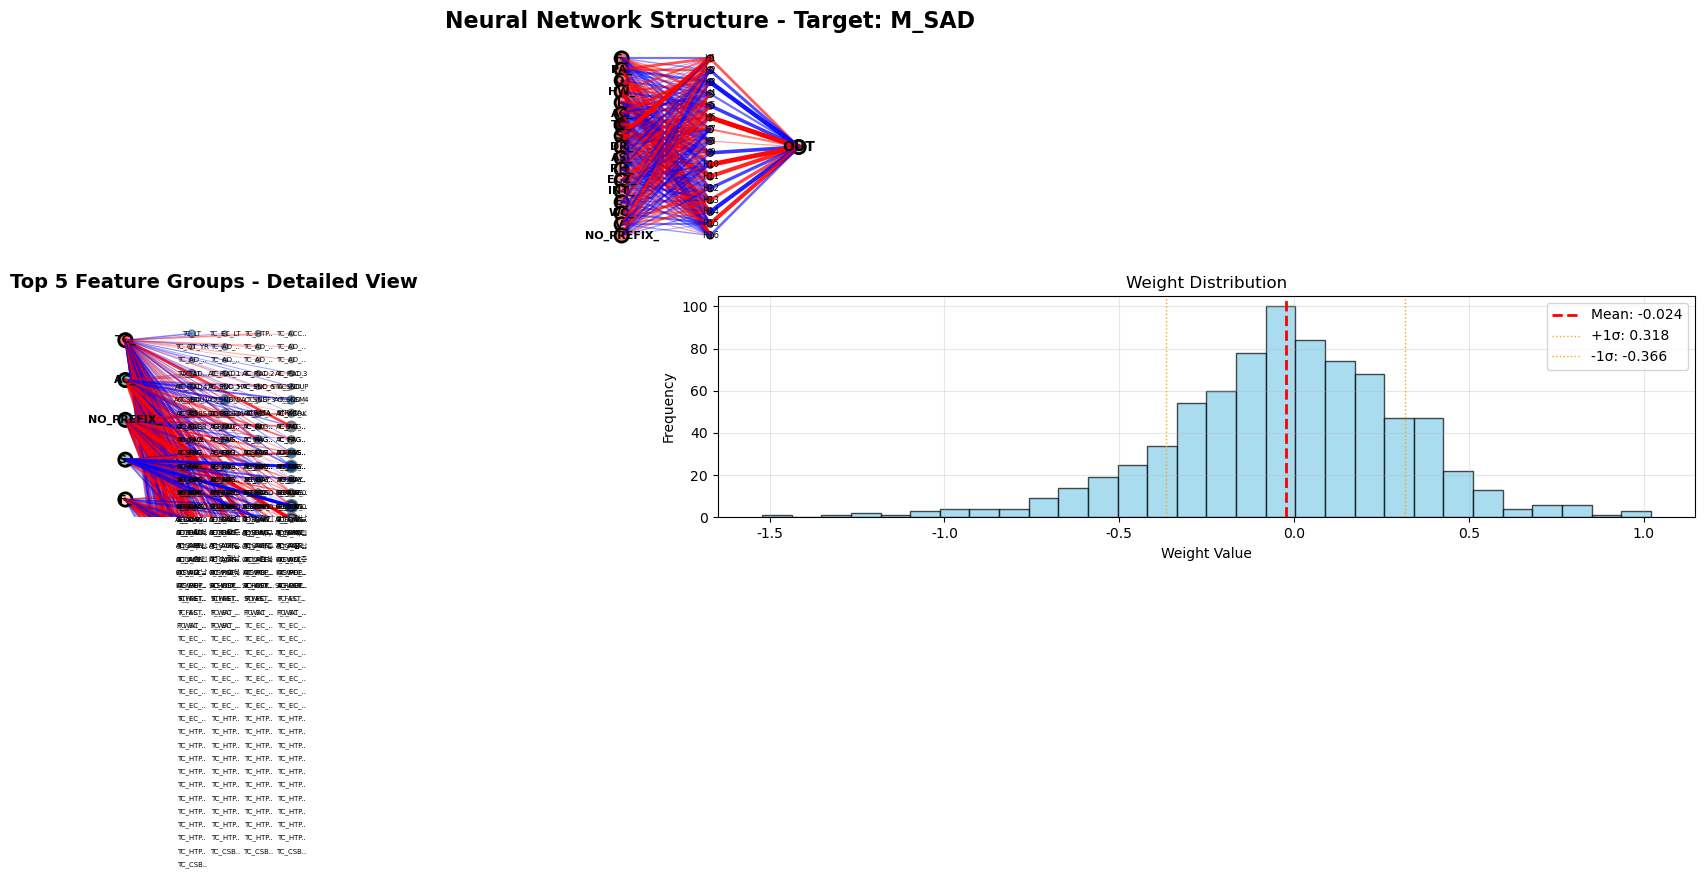

✅ 모델 'M_SAD' 분석 완료!

🚀 모델 학습 시작: Target = M_SUI_CON
🔄 모델 학습 중...
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 12.

📊 학습 결과 요약 - Target: M_SUI_CON
🔄 총 에포크 수: 16
📉 최종 Training Loss: 0.3481
📉 최종 Validation Loss: 0.3566
📈 최종 Training Accuracy: 0.8759
📈 최종 Validation Accuracy: 0.8720
📈 최종 테스트 정확도: 0.8716
📉 최종 테스트 Loss: 0.3564

🎨 네트워크 구조 시각화 생성 중...
🎨 네트워크 구조 시각화 생성 중...


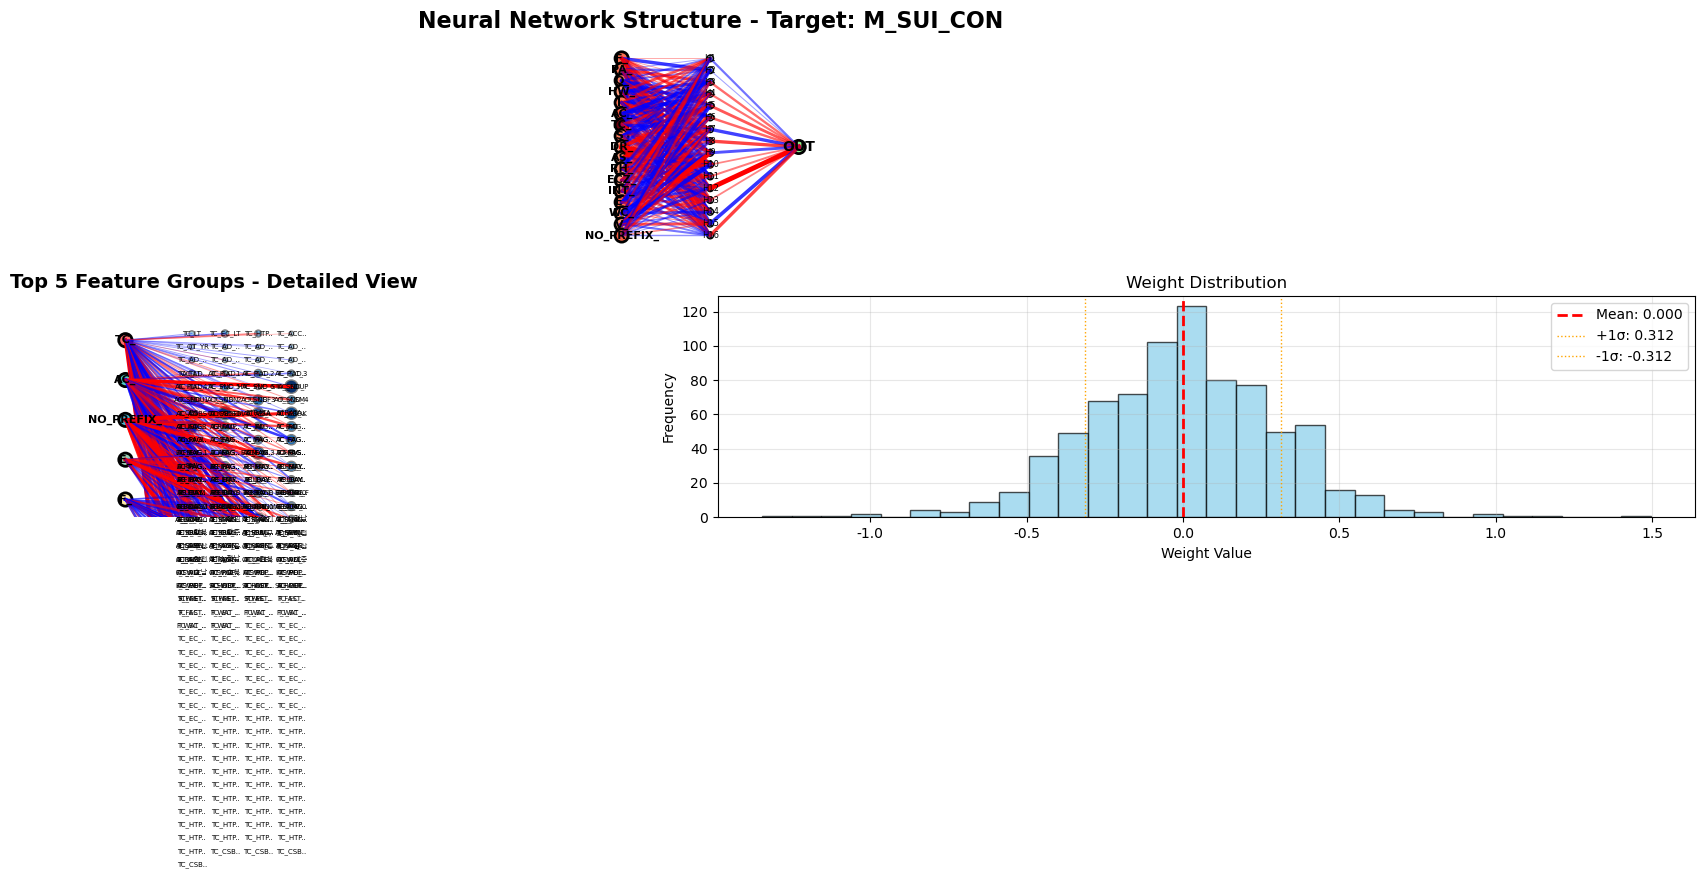

✅ 모델 'M_SUI_CON' 분석 완료!

🚀 모델 학습 시작: Target = M_SUI_PLN
🔄 모델 학습 중...
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 18.

📊 학습 결과 요약 - Target: M_SUI_PLN
🔄 총 에포크 수: 22
📉 최종 Training Loss: 0.1724
📉 최종 Validation Loss: 0.1756
📈 최종 Training Accuracy: 0.9522
📈 최종 Validation Accuracy: 0.9518
📈 최종 테스트 정확도: 0.9519
📉 최종 테스트 Loss: 0.1741

🎨 네트워크 구조 시각화 생성 중...
🎨 네트워크 구조 시각화 생성 중...


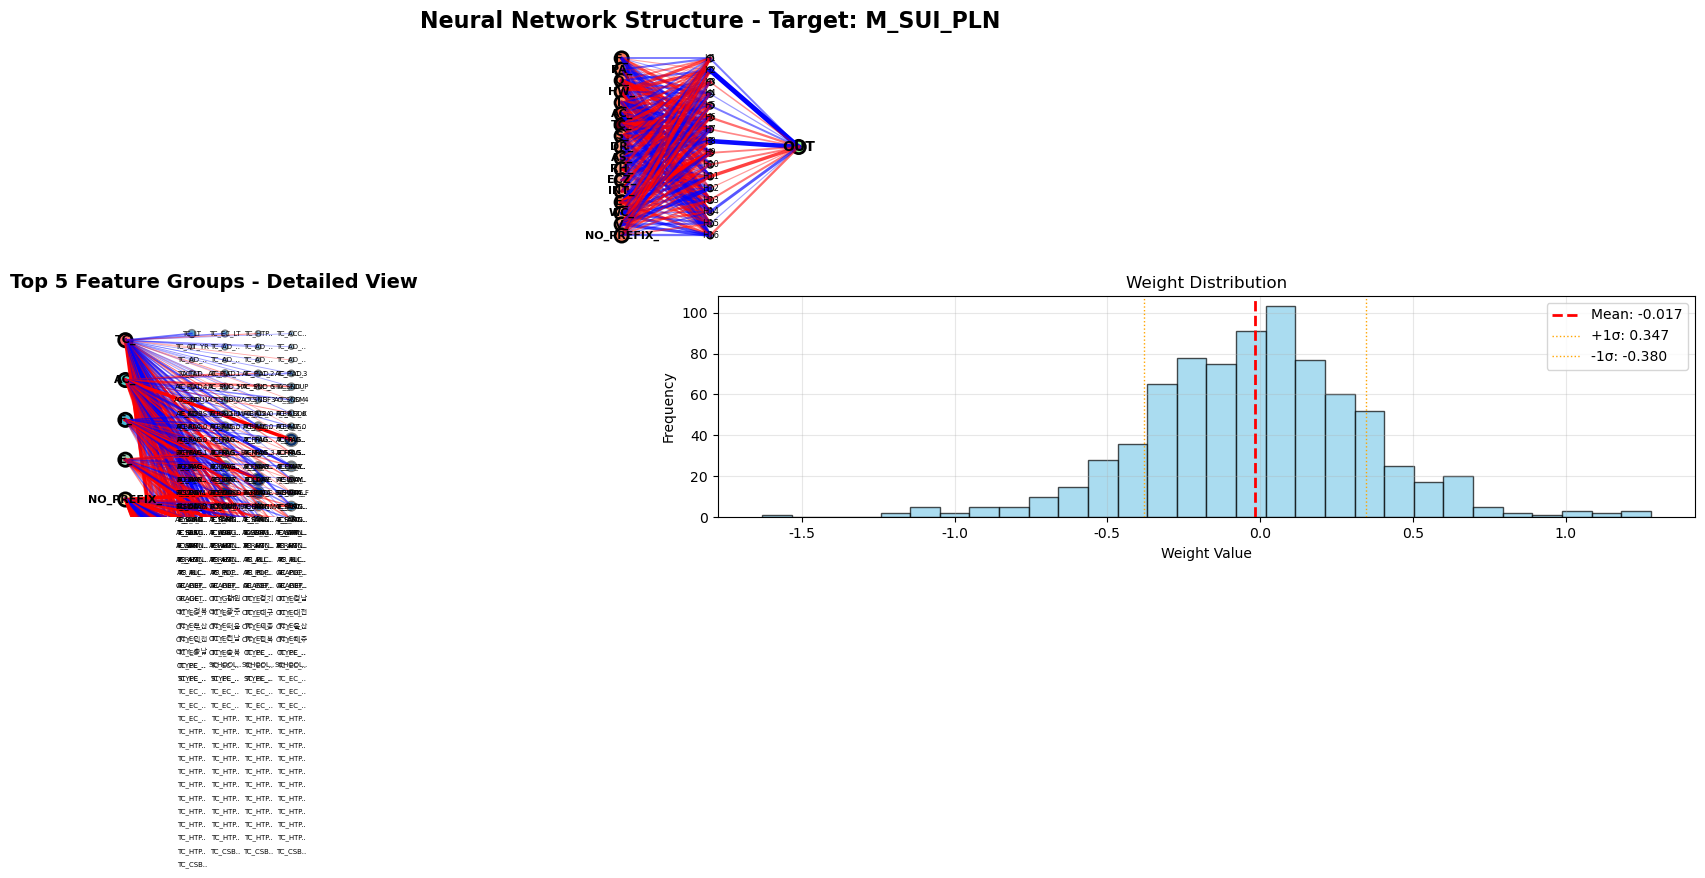

✅ 모델 'M_SUI_PLN' 분석 완료!

🚀 모델 학습 시작: Target = M_SUI_ATT
🔄 모델 학습 중...
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.

📊 학습 결과 요약 - Target: M_SUI_ATT
🔄 총 에포크 수: 5
📉 최종 Training Loss: 0.3108
📉 최종 Validation Loss: 0.1927
📈 최종 Training Accuracy: 0.9646
📈 최종 Validation Accuracy: 0.9699
📈 최종 테스트 정확도: 0.9695
📉 최종 테스트 Loss: 0.1420

🎨 네트워크 구조 시각화 생성 중...
🎨 네트워크 구조 시각화 생성 중...


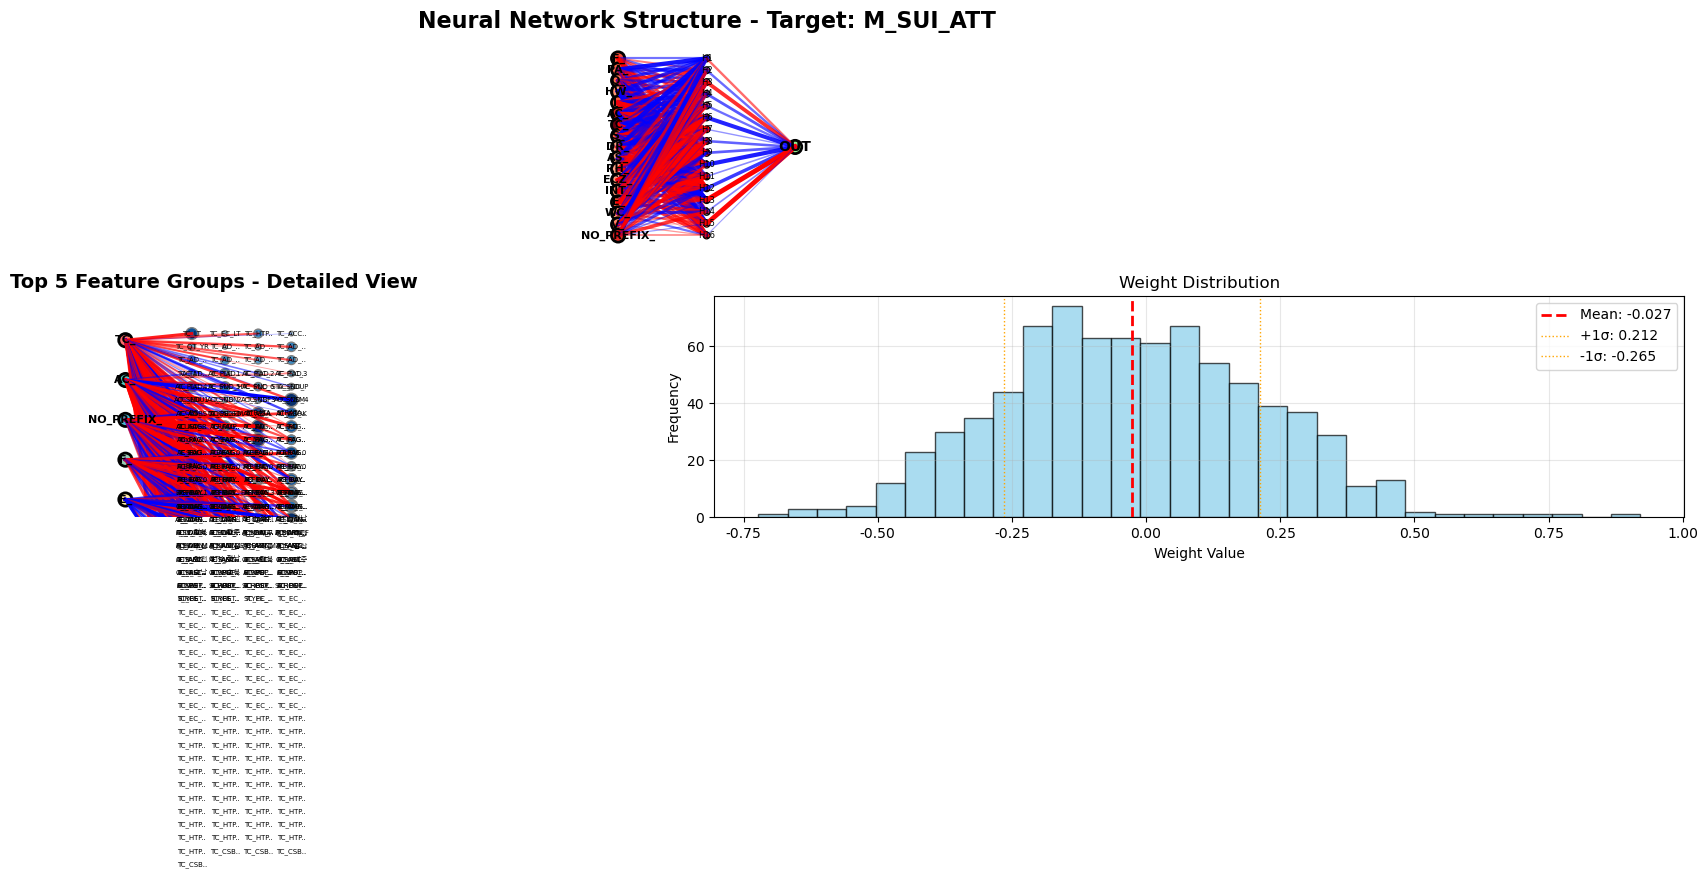

✅ 모델 'M_SUI_ATT' 분석 완료!

🚀 모델 학습 시작: Target = M_GAD_1
🔄 모델 학습 중...
Restoring model weights from the end of the best epoch: 100.

📊 학습 결과 요약 - Target: M_GAD_1
🔄 총 에포크 수: 100
📉 최종 Training Loss: -640610598912.0000
📉 최종 Validation Loss: -649443999744.0000
📈 최종 Training Accuracy: 0.5107
📈 최종 Validation Accuracy: 0.5107
📈 최종 테스트 정확도: 0.5107
📉 최종 테스트 Loss: -649443999744.0000

🎨 네트워크 구조 시각화 생성 중...
🎨 네트워크 구조 시각화 생성 중...


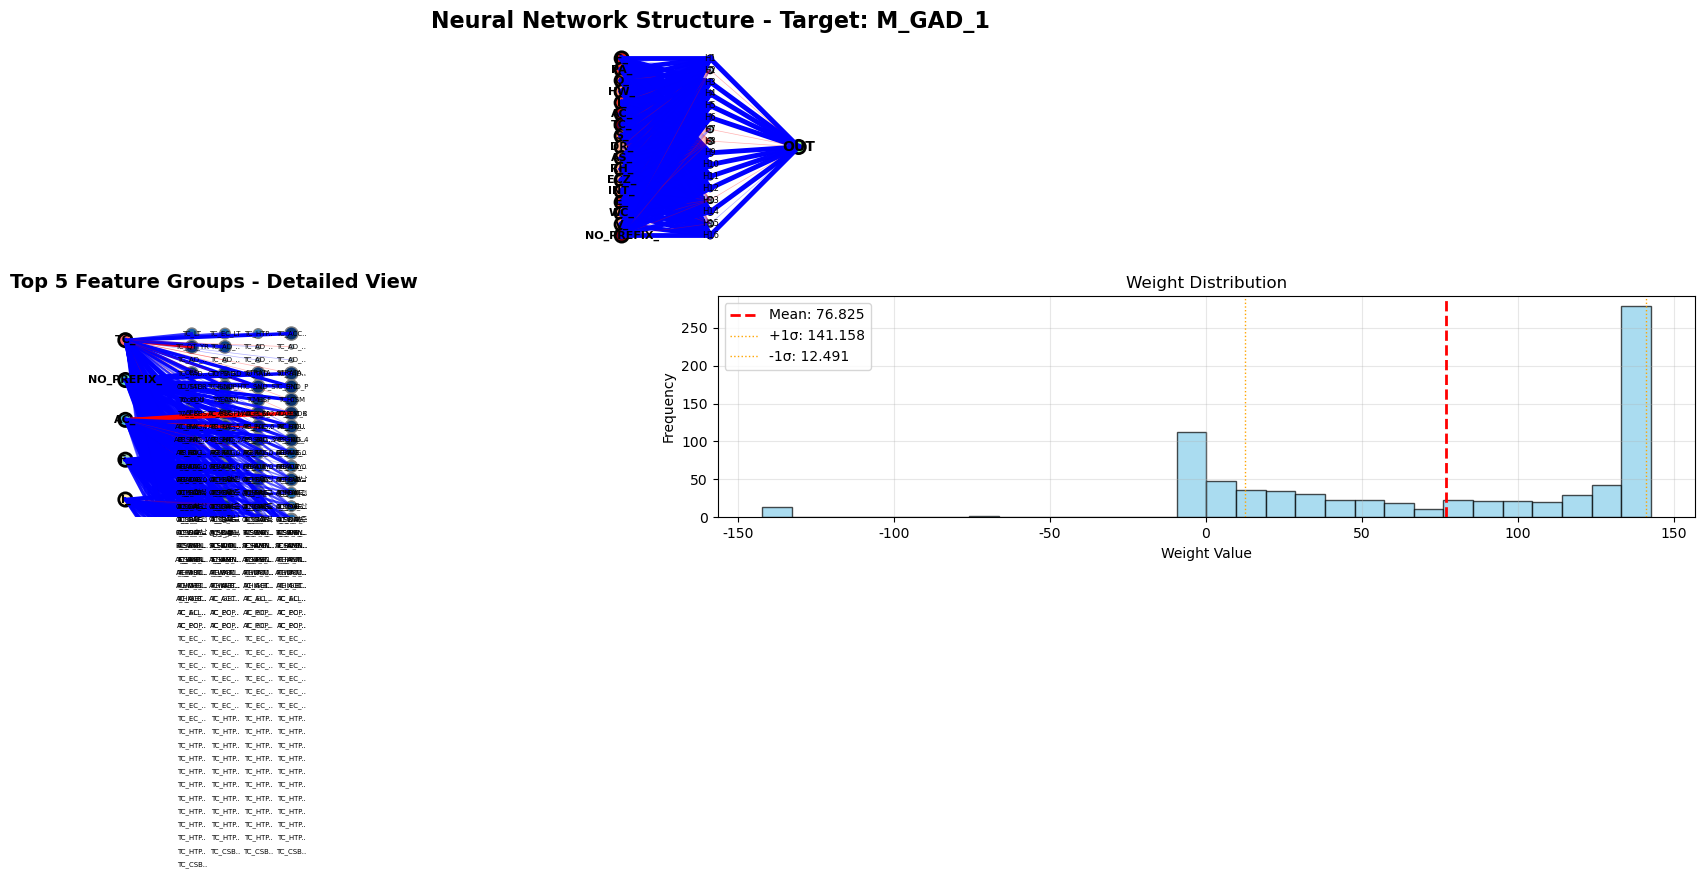

✅ 모델 'M_GAD_1' 분석 완료!

🚀 모델 학습 시작: Target = M_GAD_2
🔄 모델 학습 중...
Restoring model weights from the end of the best epoch: 100.

📊 학습 결과 요약 - Target: M_GAD_2
🔄 총 에포크 수: 100
📉 최종 Training Loss: -415022055424.0000
📉 최종 Validation Loss: -414232018944.0000
📈 최종 Training Accuracy: 0.5315
📈 최종 Validation Accuracy: 0.5371
📈 최종 테스트 정확도: 0.5371
📉 최종 테스트 Loss: -414232018944.0000

🎨 네트워크 구조 시각화 생성 중...
🎨 네트워크 구조 시각화 생성 중...


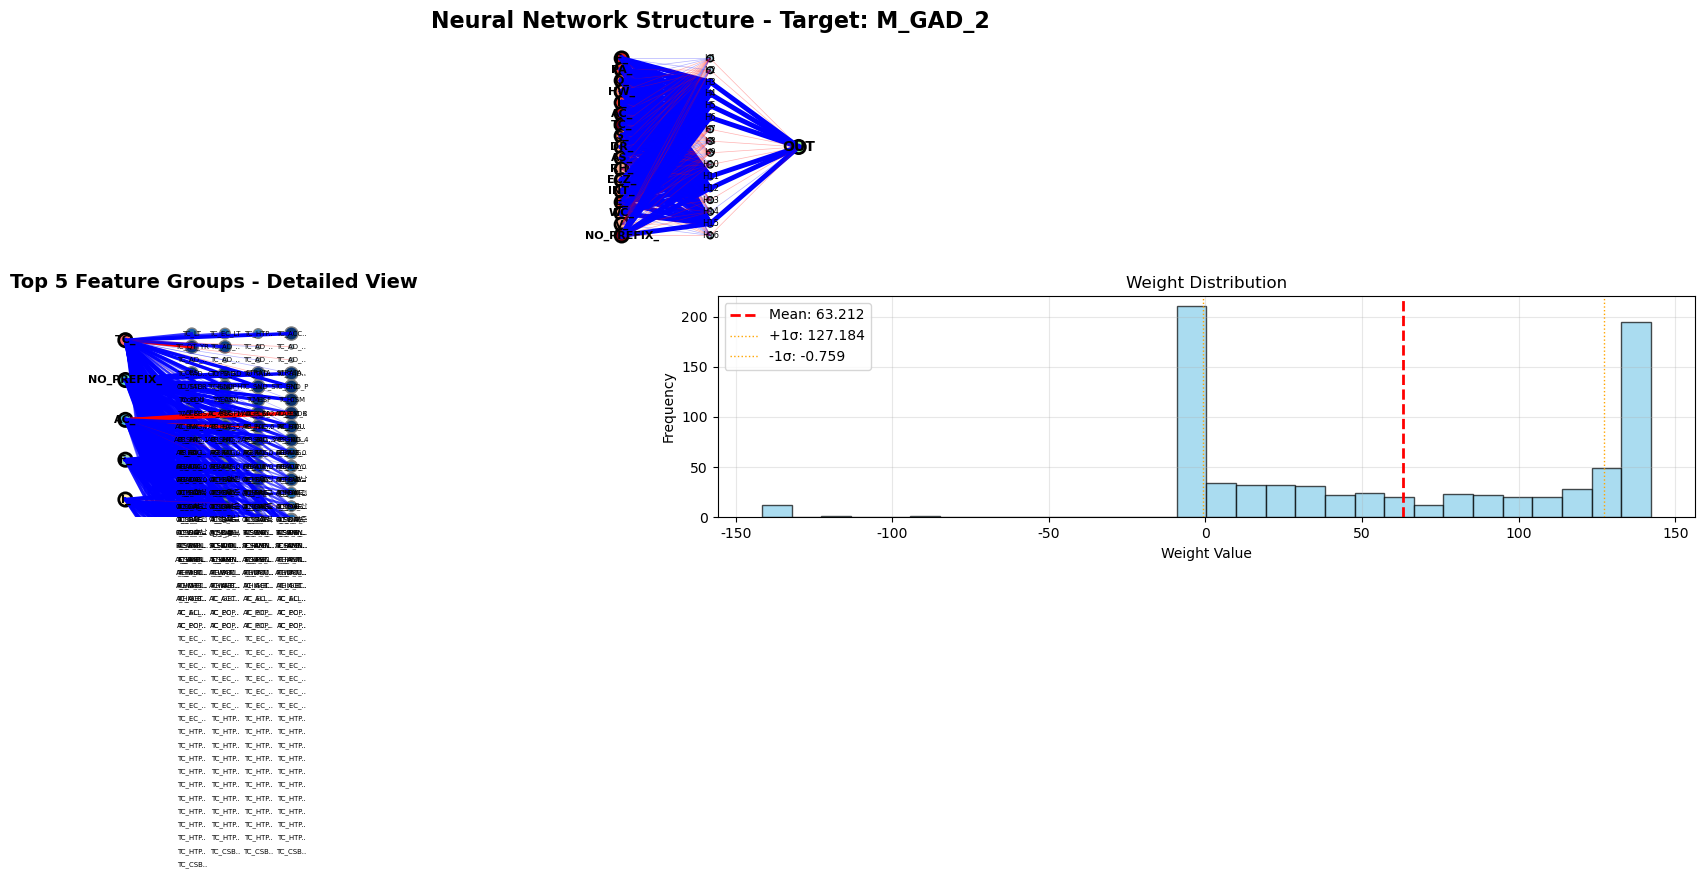

✅ 모델 'M_GAD_2' 분석 완료!

🚀 모델 학습 시작: Target = M_GAD_3
🔄 모델 학습 중...
Restoring model weights from the end of the best epoch: 100.

📊 학습 결과 요약 - Target: M_GAD_3
🔄 총 에포크 수: 100
📉 최종 Training Loss: -846716928000.0000
📉 최종 Validation Loss: -852151894016.0000
📈 최종 Training Accuracy: 0.3462
📈 최종 Validation Accuracy: 0.3463
📈 최종 테스트 정확도: 0.3463
📉 최종 테스트 Loss: -852151894016.0000

🎨 네트워크 구조 시각화 생성 중...
🎨 네트워크 구조 시각화 생성 중...


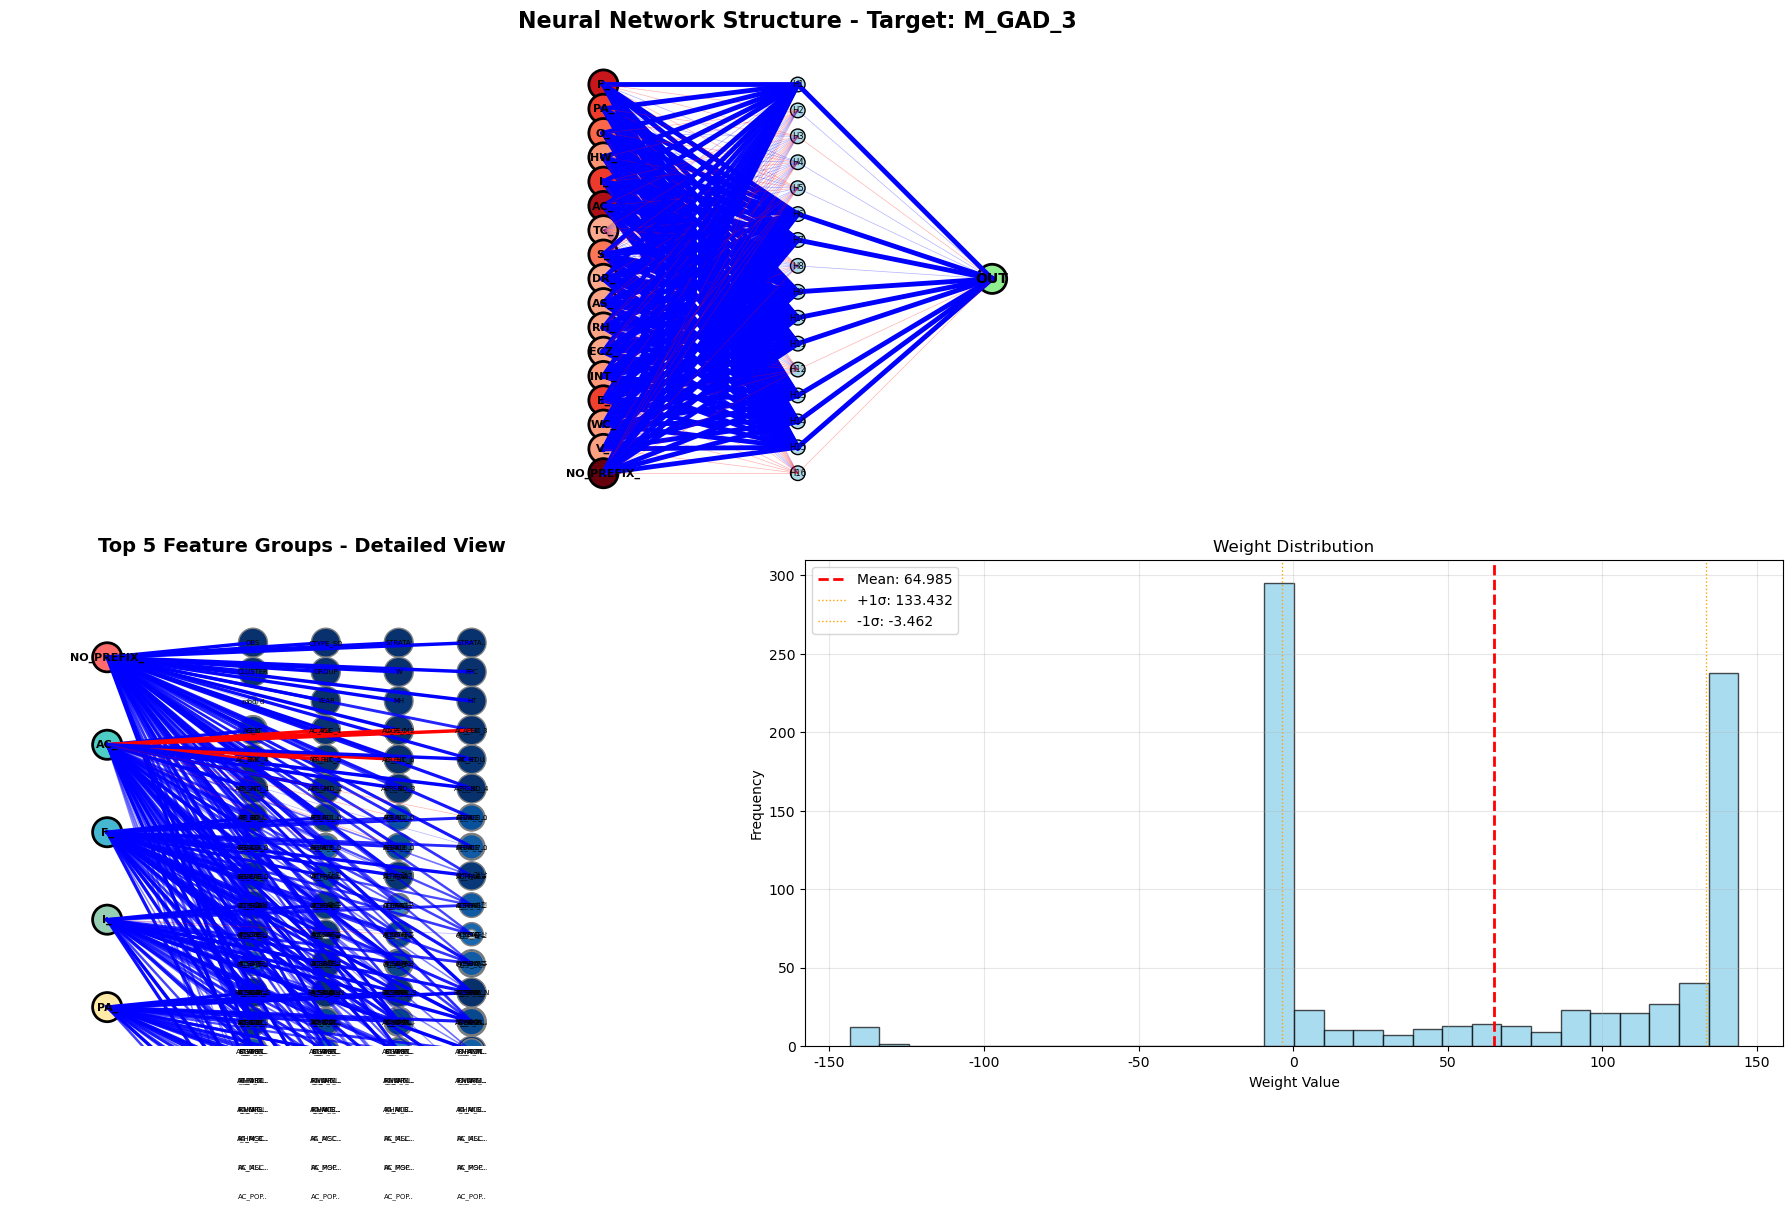

✅ 모델 'M_GAD_3' 분석 완료!

🚀 모델 학습 시작: Target = M_GAD_4
🔄 모델 학습 중...
Restoring model weights from the end of the best epoch: 100.

📊 학습 결과 요약 - Target: M_GAD_4
🔄 총 에포크 수: 100
📉 최종 Training Loss: -24762036224.0000
📉 최종 Validation Loss: -25021190144.0000
📈 최종 Training Accuracy: 0.6309
📈 최종 Validation Accuracy: 0.6342
📈 최종 테스트 정확도: 0.6342
📉 최종 테스트 Loss: -25021190144.0000

🎨 네트워크 구조 시각화 생성 중...
🎨 네트워크 구조 시각화 생성 중...


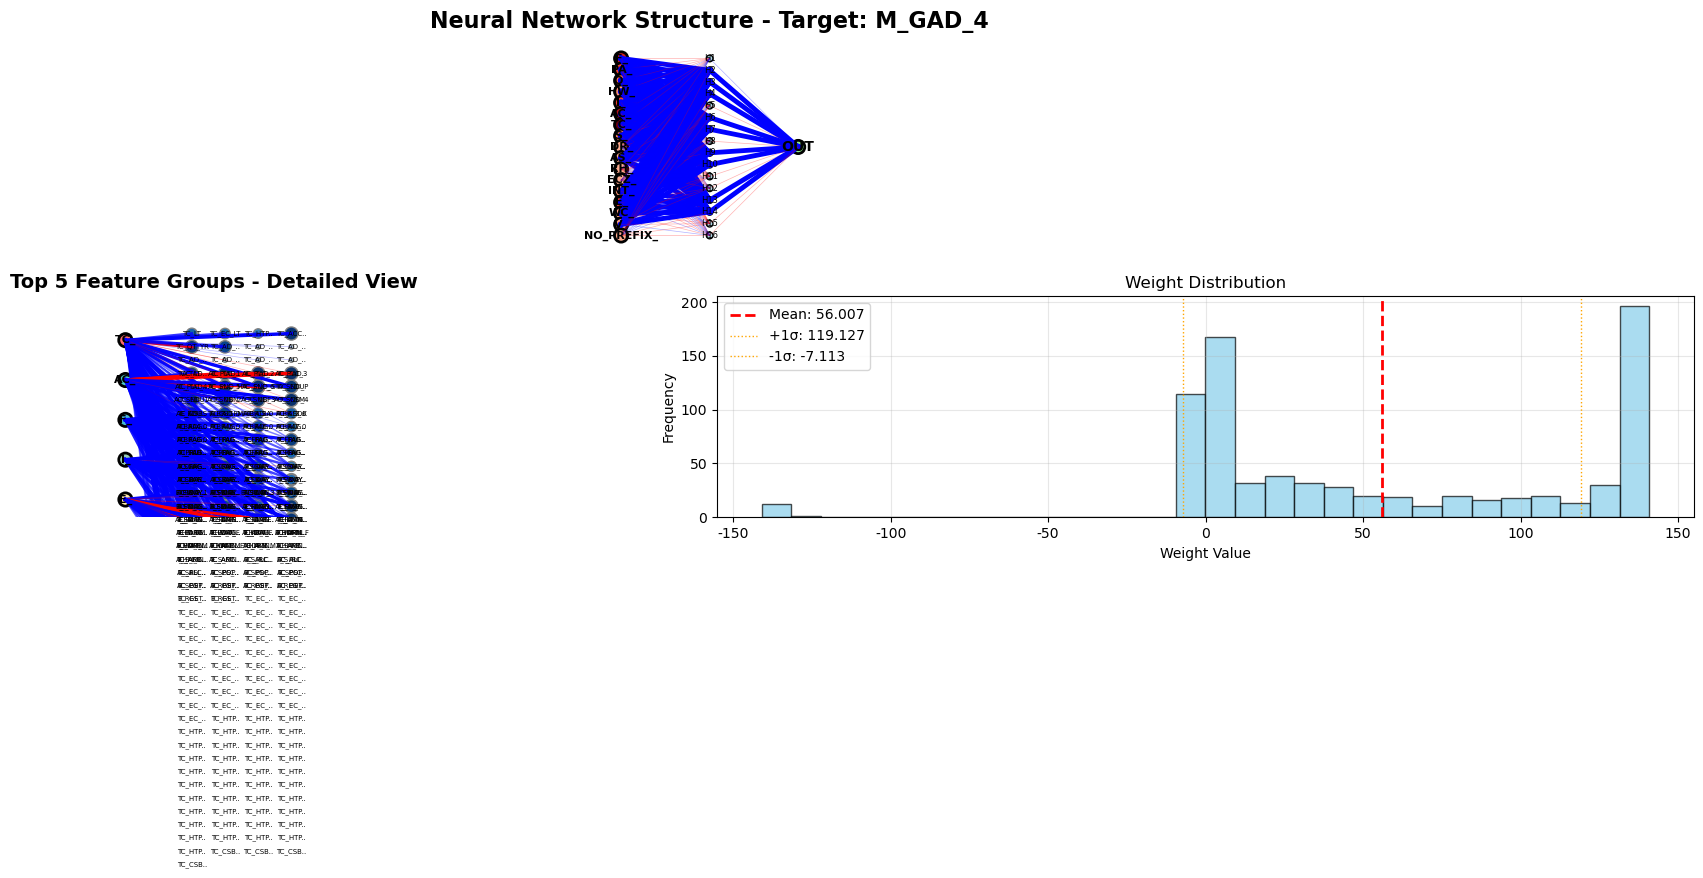

✅ 모델 'M_GAD_4' 분석 완료!

🚀 모델 학습 시작: Target = M_GAD_5
🔄 모델 학습 중...
Restoring model weights from the end of the best epoch: 100.

📊 학습 결과 요약 - Target: M_GAD_5
🔄 총 에포크 수: 100
📉 최종 Training Loss: -229746245632.0000
📉 최종 Validation Loss: -232034844672.0000
📈 최종 Training Accuracy: 0.7588
📈 최종 Validation Accuracy: 0.7635
📈 최종 테스트 정확도: 0.7635
📉 최종 테스트 Loss: -232034844672.0000

🎨 네트워크 구조 시각화 생성 중...
🎨 네트워크 구조 시각화 생성 중...


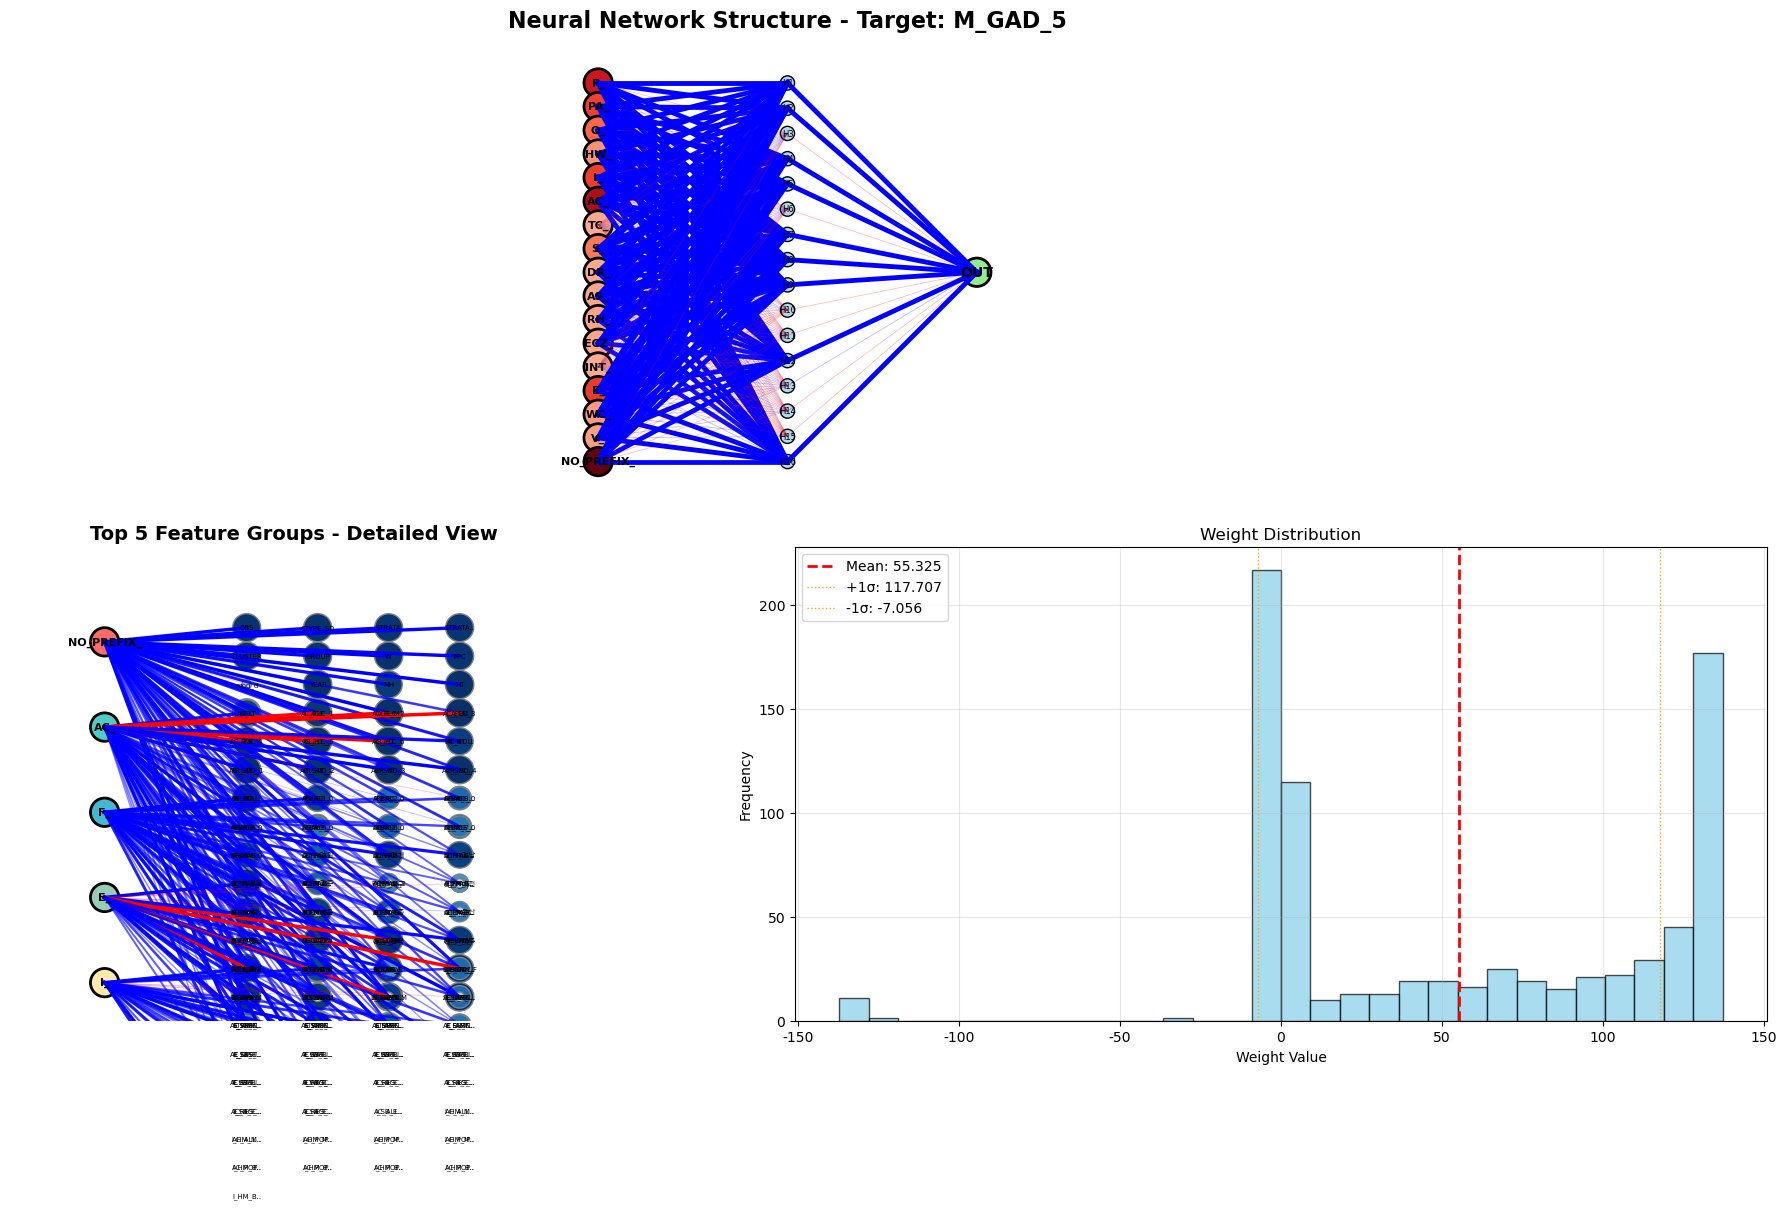

✅ 모델 'M_GAD_5' 분석 완료!

🚀 모델 학습 시작: Target = M_GAD_6
🔄 모델 학습 중...
Restoring model weights from the end of the best epoch: 100.

📊 학습 결과 요약 - Target: M_GAD_6
🔄 총 에포크 수: 100
📉 최종 Training Loss: -625226874880.0000
📉 최종 Validation Loss: -628657553408.0000
📈 최종 Training Accuracy: 0.4656
📈 최종 Validation Accuracy: 0.4681
📈 최종 테스트 정확도: 0.4681
📉 최종 테스트 Loss: -628657553408.0000

🎨 네트워크 구조 시각화 생성 중...
🎨 네트워크 구조 시각화 생성 중...


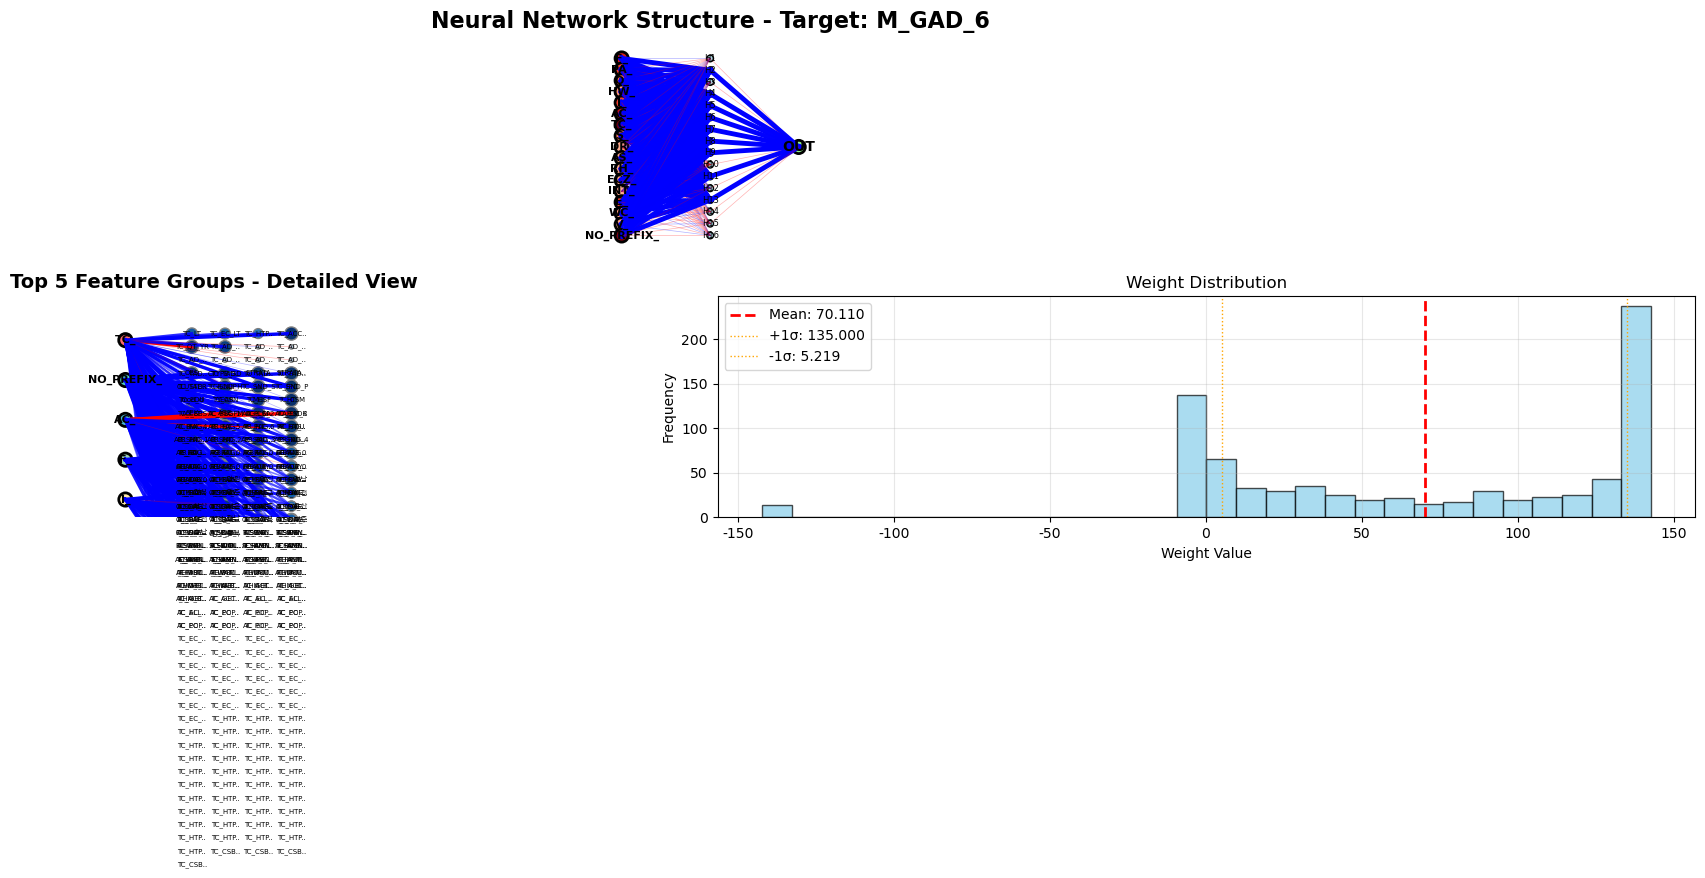

✅ 모델 'M_GAD_6' 분석 완료!

🚀 모델 학습 시작: Target = M_GAD_7
🔄 모델 학습 중...
Restoring model weights from the end of the best epoch: 100.

📊 학습 결과 요약 - Target: M_GAD_7
🔄 총 에포크 수: 100
📉 최종 Training Loss: -24397756416.0000
📉 최종 Validation Loss: -24482293760.0000
📈 최종 Training Accuracy: 0.7189
📈 최종 Validation Accuracy: 0.7235
📈 최종 테스트 정확도: 0.7235
📉 최종 테스트 Loss: -24482293760.0000

🎨 네트워크 구조 시각화 생성 중...
🎨 네트워크 구조 시각화 생성 중...


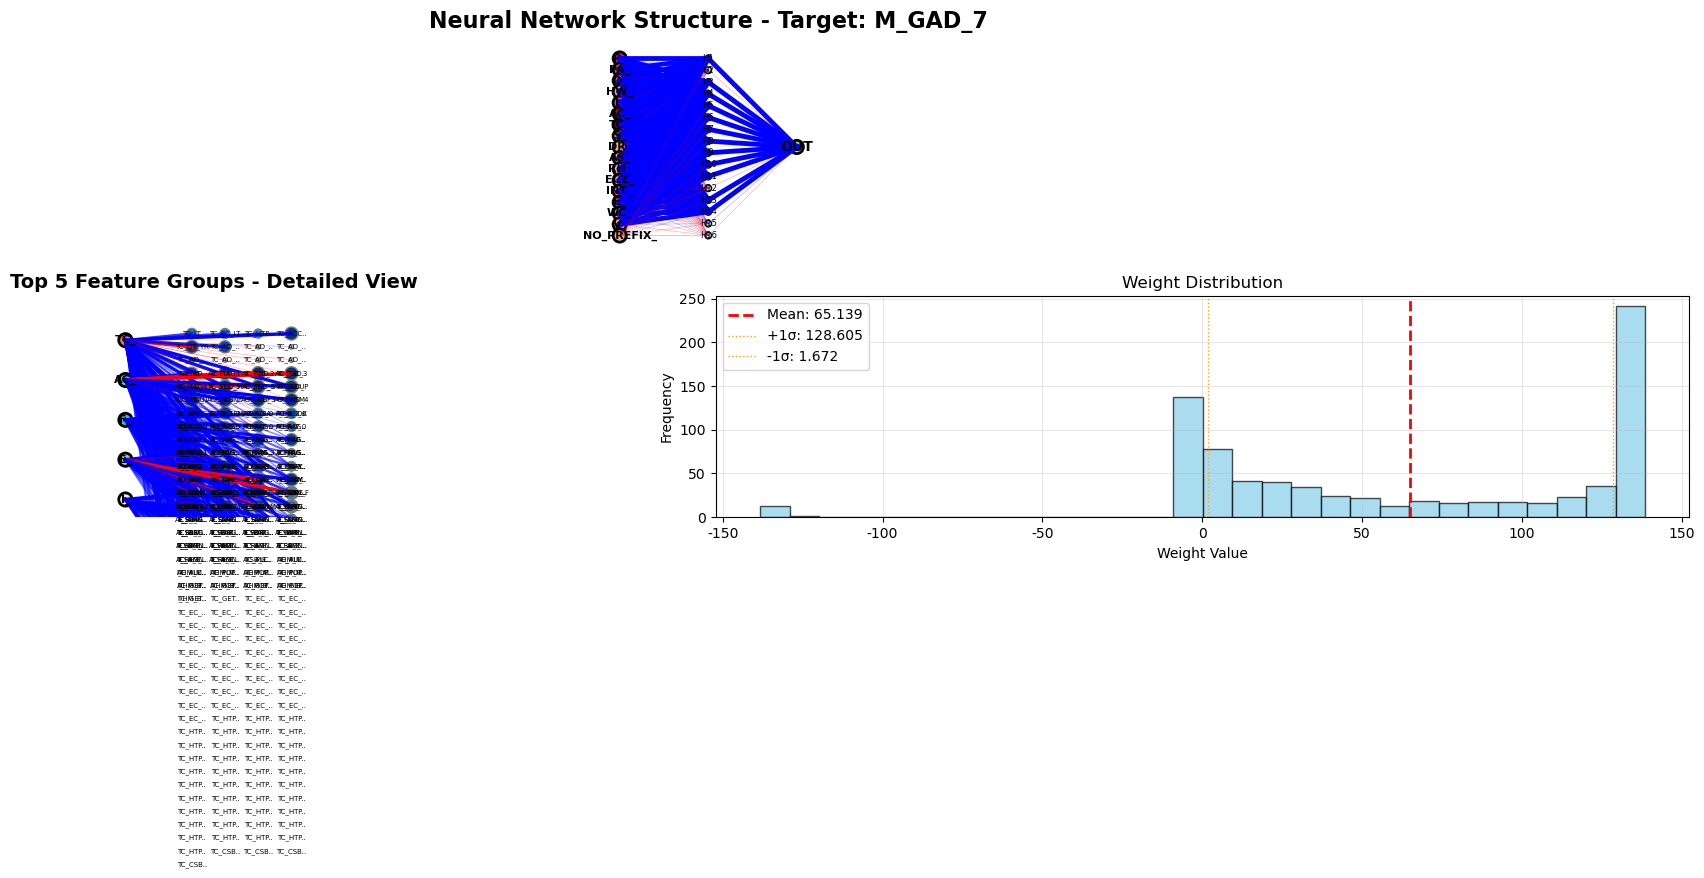

✅ 모델 'M_GAD_7' 분석 완료!

🚀 모델 학습 시작: Target = M_GAD_TOTAL
🔄 모델 학습 중...
Restoring model weights from the end of the best epoch: 100.

📊 학습 결과 요약 - Target: M_GAD_TOTAL
🔄 총 에포크 수: 100
📉 최종 Training Loss: -2979481255936.0000
📉 최종 Validation Loss: -2997988622336.0000
📈 최종 Training Accuracy: 0.1099
📈 최종 Validation Accuracy: 0.1100
📈 최종 테스트 정확도: 0.1100
📉 최종 테스트 Loss: -2997988622336.0000

🎨 네트워크 구조 시각화 생성 중...
🎨 네트워크 구조 시각화 생성 중...


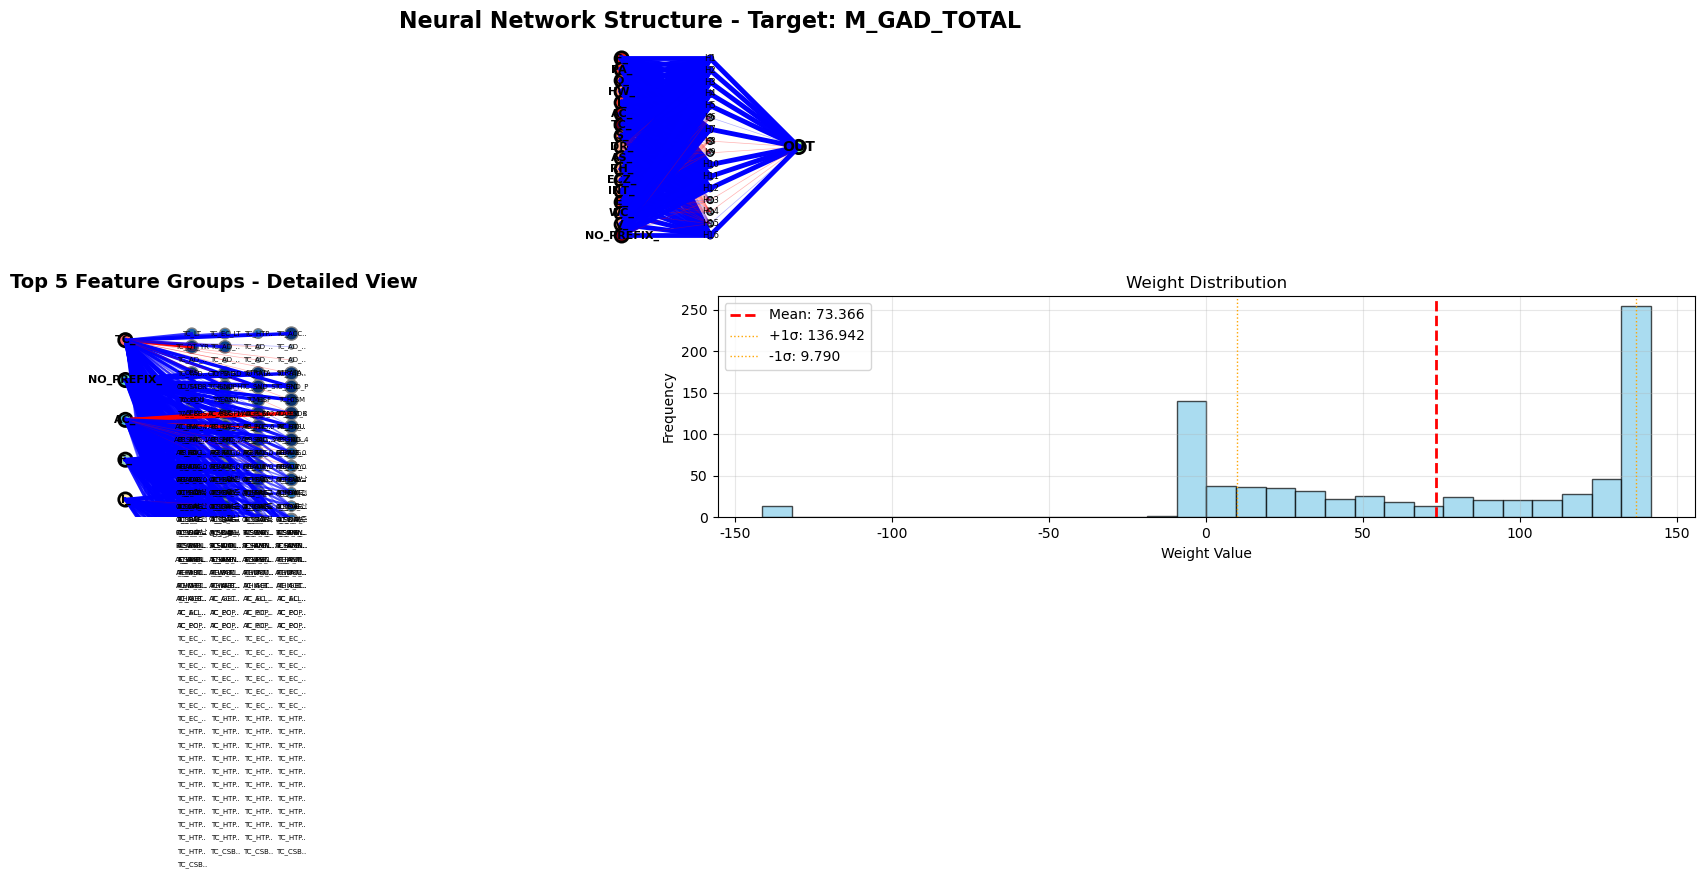

✅ 모델 'M_GAD_TOTAL' 분석 완료!

🚀 모델 학습 시작: Target = M_GAD_SEVERITY
🔄 모델 학습 중...
Restoring model weights from the end of the best epoch: 100.

📊 학습 결과 요약 - Target: M_GAD_SEVERITY
🔄 총 에포크 수: 100
📉 최종 Training Loss: -6277.9614
📉 최종 Validation Loss: -3804.4717
📈 최종 Training Accuracy: 0.5048
📈 최종 Validation Accuracy: 0.5017
📈 최종 테스트 정확도: 0.5017
📉 최종 테스트 Loss: -3804.4717

🎨 네트워크 구조 시각화 생성 중...
🎨 네트워크 구조 시각화 생성 중...


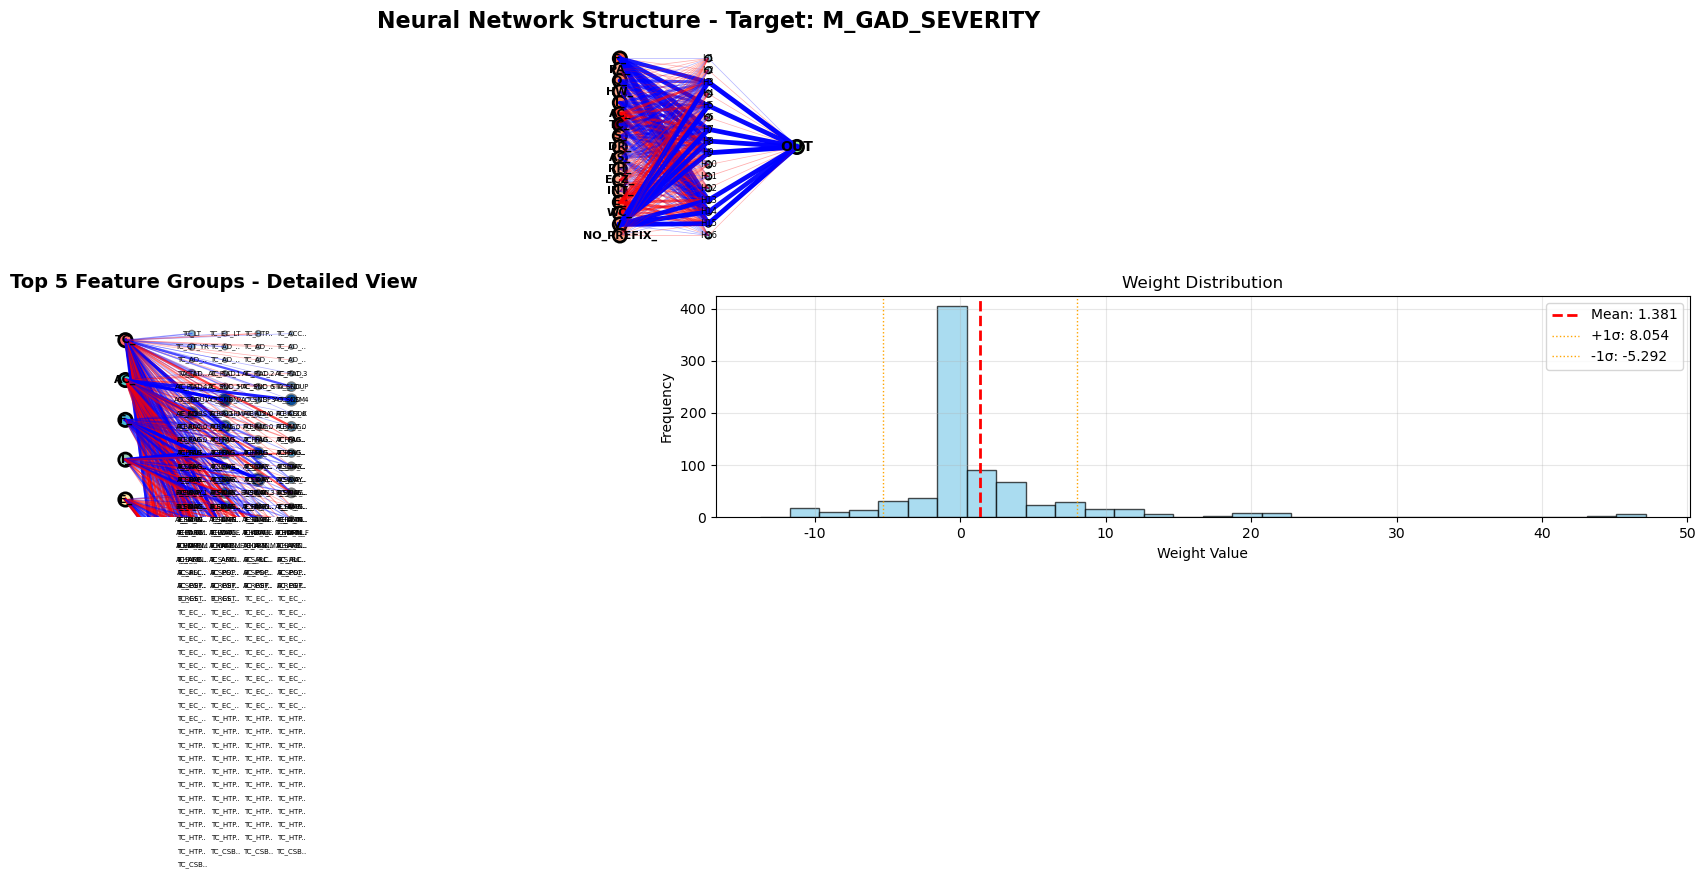

✅ 모델 'M_GAD_SEVERITY' 분석 완료!

🚀 모델 학습 시작: Target = M_STR_1.0
🔄 모델 학습 중...
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.

📊 학습 결과 요약 - Target: M_STR_1.0
🔄 총 에포크 수: 5
📉 최종 Training Loss: 0.4509
📉 최종 Validation Loss: 0.3937
📈 최종 Training Accuracy: 0.8664
📈 최종 Validation Accuracy: 0.8851
📈 최종 테스트 정확도: 0.8856
📉 최종 테스트 Loss: 0.3662

🎨 네트워크 구조 시각화 생성 중...
🎨 네트워크 구조 시각화 생성 중...


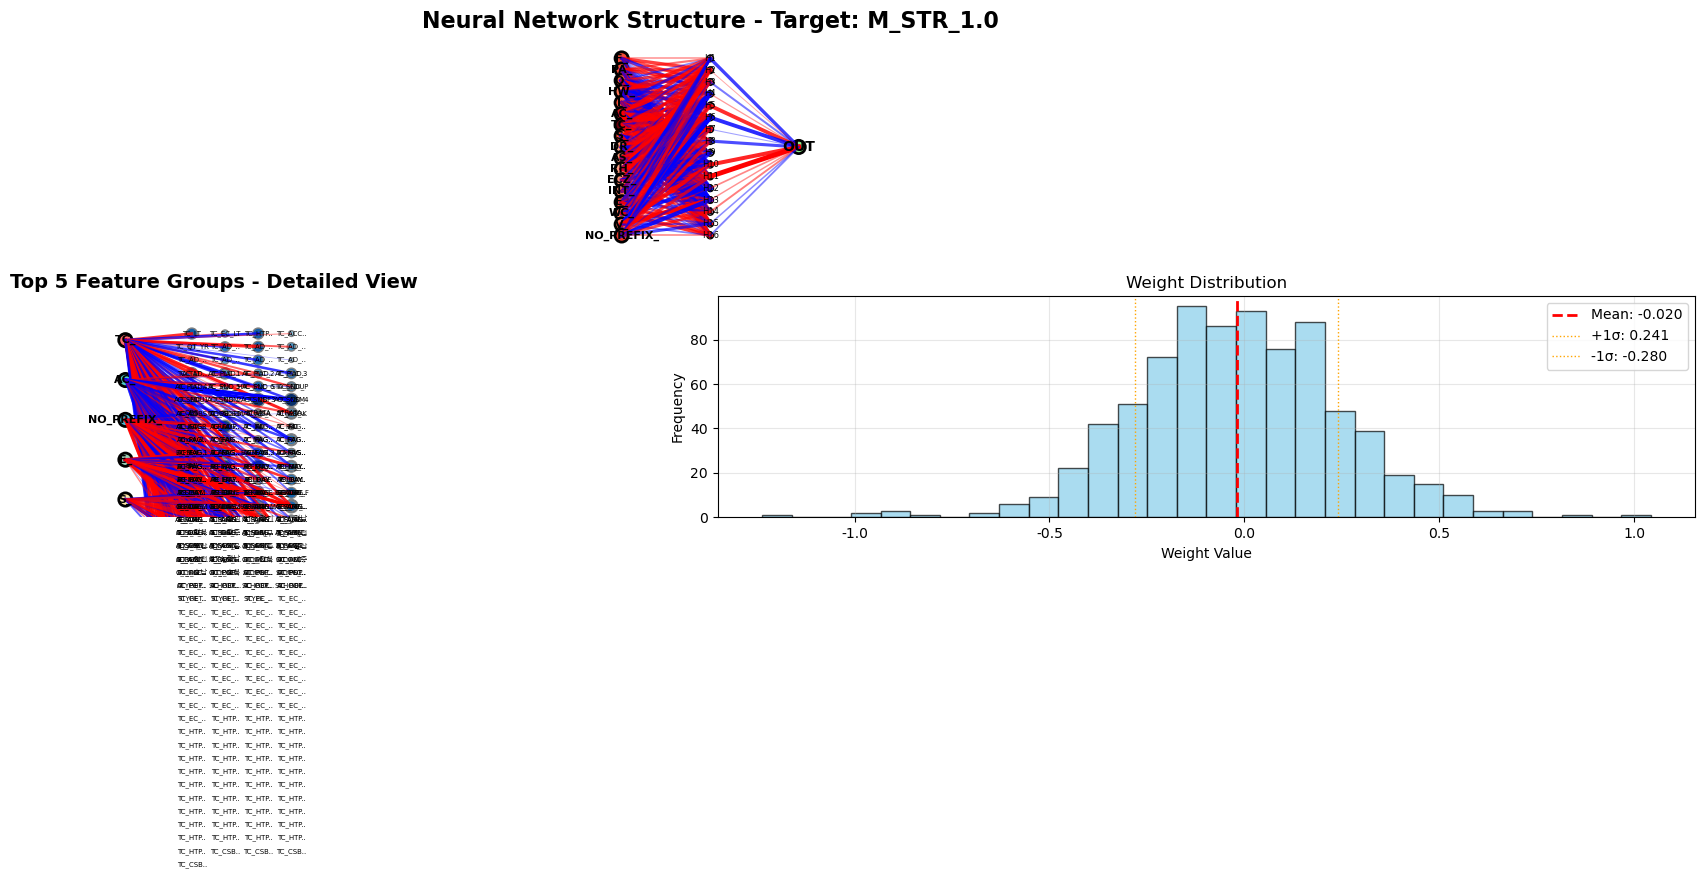

✅ 모델 'M_STR_1.0' 분석 완료!

🚀 모델 학습 시작: Target = M_STR_2.0
🔄 모델 학습 중...
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 12.

📊 학습 결과 요약 - Target: M_STR_2.0
🔄 총 에포크 수: 16
📉 최종 Training Loss: 0.6056
📉 최종 Validation Loss: 0.6095
📈 최종 Training Accuracy: 0.6906
📈 최종 Validation Accuracy: 0.6910
📈 최종 테스트 정확도: 0.6910
📉 최종 테스트 Loss: 0.6079

🎨 네트워크 구조 시각화 생성 중...
🎨 네트워크 구조 시각화 생성 중...


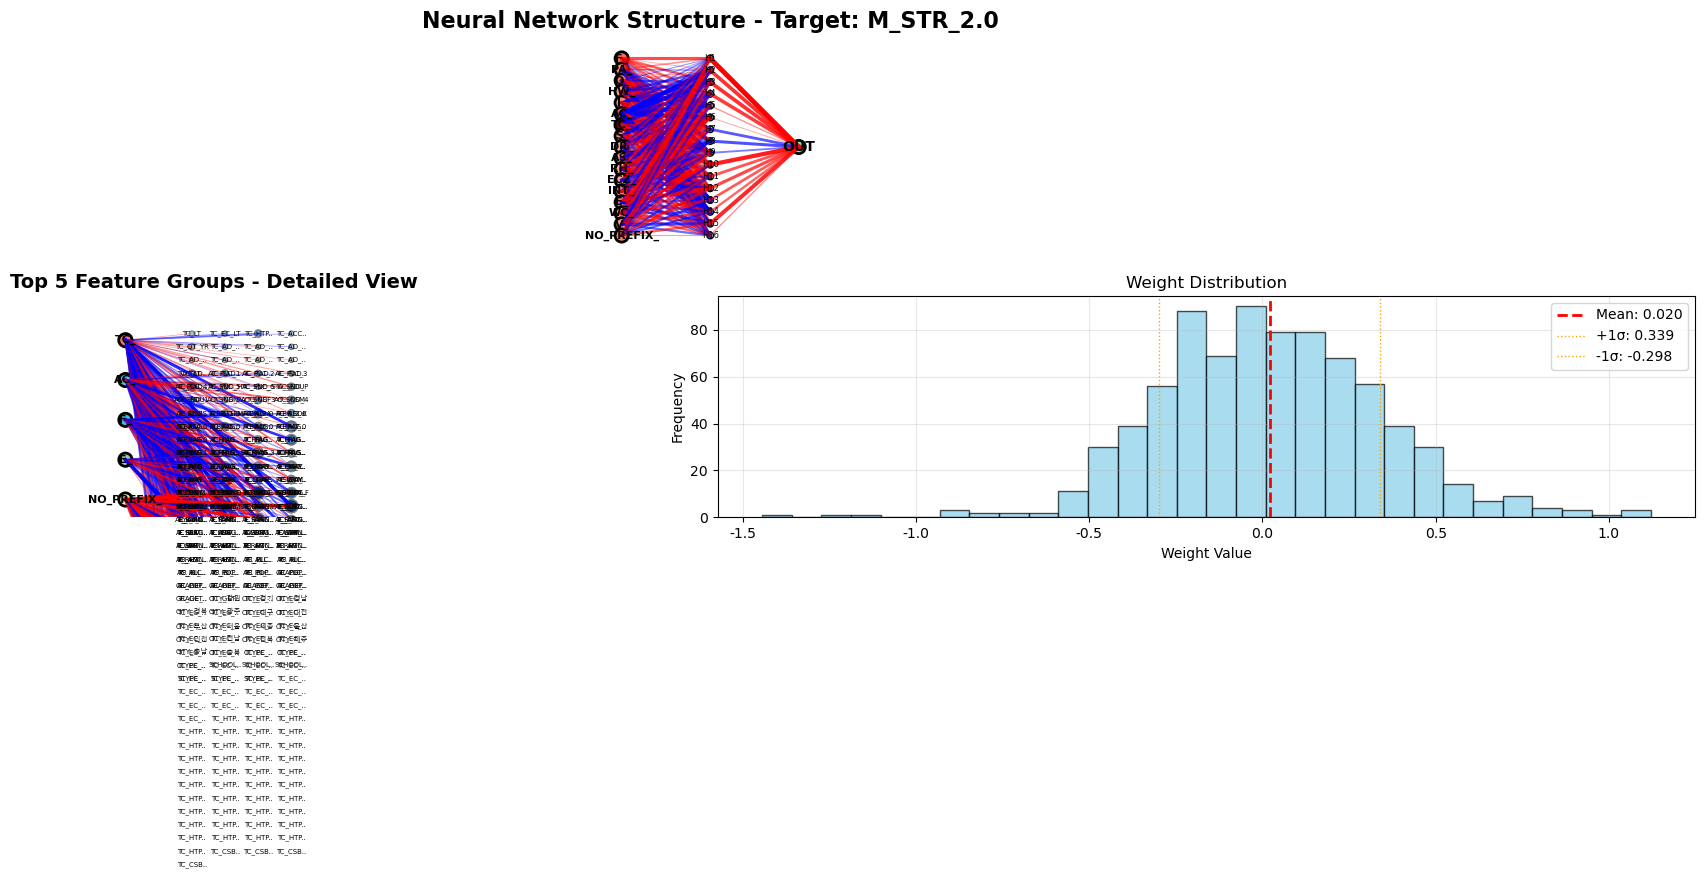

✅ 모델 'M_STR_2.0' 분석 완료!

🚀 모델 학습 시작: Target = M_STR_3.0
🔄 모델 학습 중...
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 8.

📊 학습 결과 요약 - Target: M_STR_3.0
🔄 총 에포크 수: 12
📉 최종 Training Loss: 0.6669
📉 최종 Validation Loss: 0.6712
📈 최종 Training Accuracy: 0.5805
📈 최종 Validation Accuracy: 0.5830
📈 최종 테스트 정확도: 0.5845
📉 최종 테스트 Loss: 0.6712

🎨 네트워크 구조 시각화 생성 중...
🎨 네트워크 구조 시각화 생성 중...


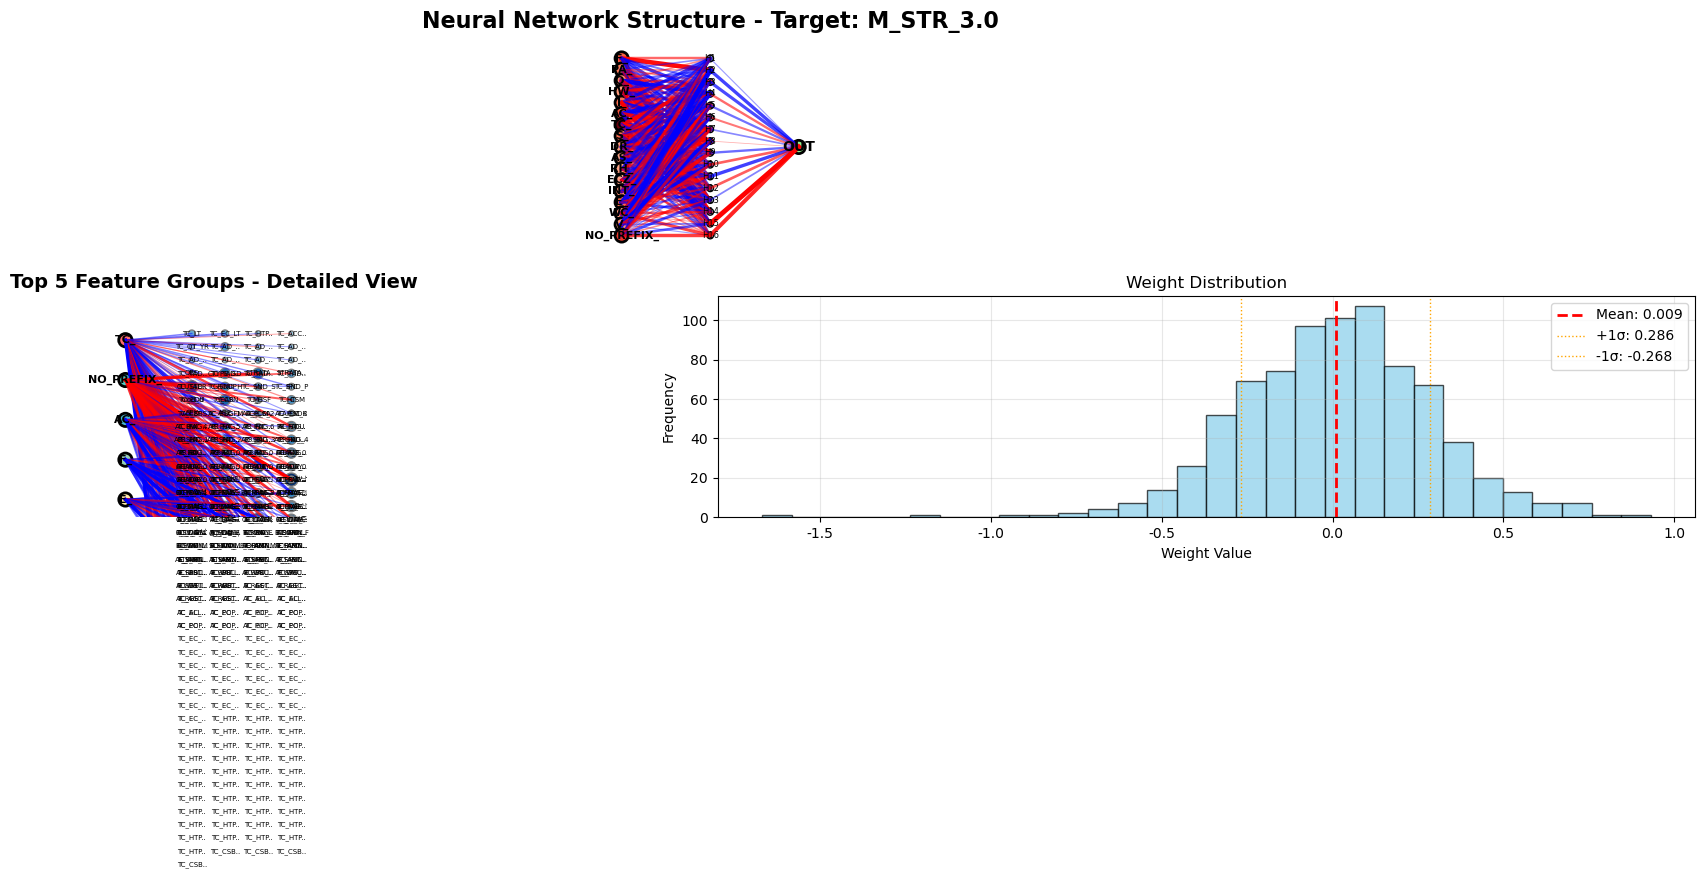

✅ 모델 'M_STR_3.0' 분석 완료!

🚀 모델 학습 시작: Target = M_STR_4.0
🔄 모델 학습 중...
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 5.

📊 학습 결과 요약 - Target: M_STR_4.0
🔄 총 에포크 수: 9
📉 최종 Training Loss: 0.3715
📉 최종 Validation Loss: 0.3783
📈 최종 Training Accuracy: 0.8713
📈 최종 Validation Accuracy: 0.8689
📈 최종 테스트 정확도: 0.8689
📉 최종 테스트 Loss: 0.3777

🎨 네트워크 구조 시각화 생성 중...
🎨 네트워크 구조 시각화 생성 중...


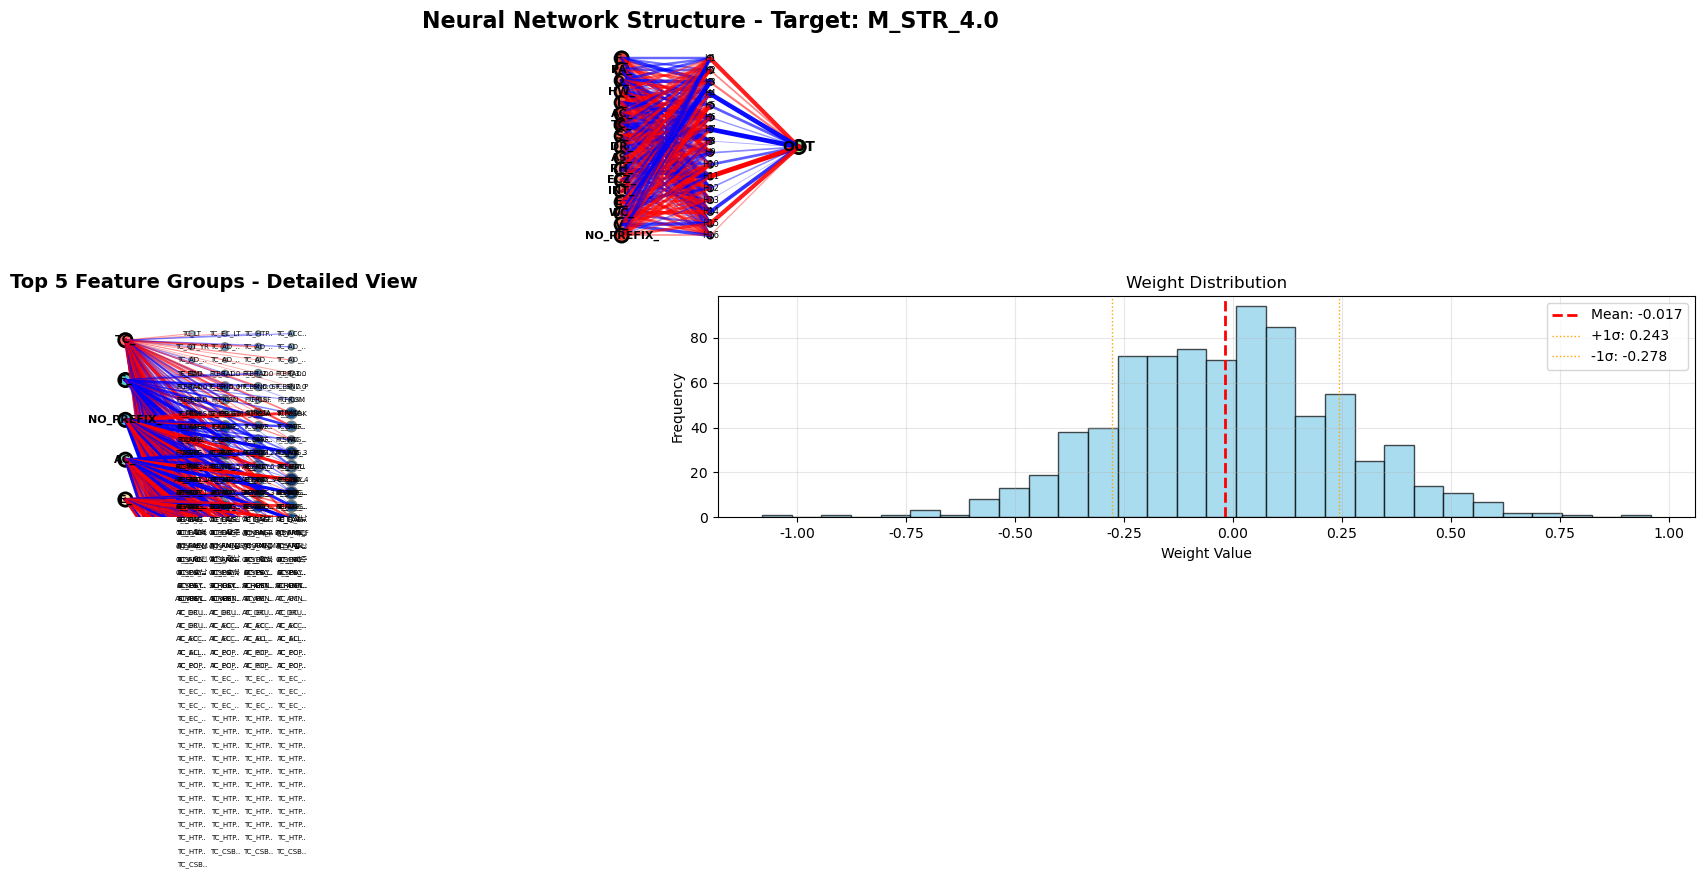

✅ 모델 'M_STR_4.0' 분석 완료!

🚀 모델 학습 시작: Target = M_STR_5.0
🔄 모델 학습 중...
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 13.

📊 학습 결과 요약 - Target: M_STR_5.0
🔄 총 에포크 수: 17
📉 최종 Training Loss: 0.1180
📉 최종 Validation Loss: 0.1242
📈 최종 Training Accuracy: 0.9710
📈 최종 Validation Accuracy: 0.9707
📈 최종 테스트 정확도: 0.9707
📉 최종 테스트 Loss: 0.1230

🎨 네트워크 구조 시각화 생성 중...
🎨 네트워크 구조 시각화 생성 중...


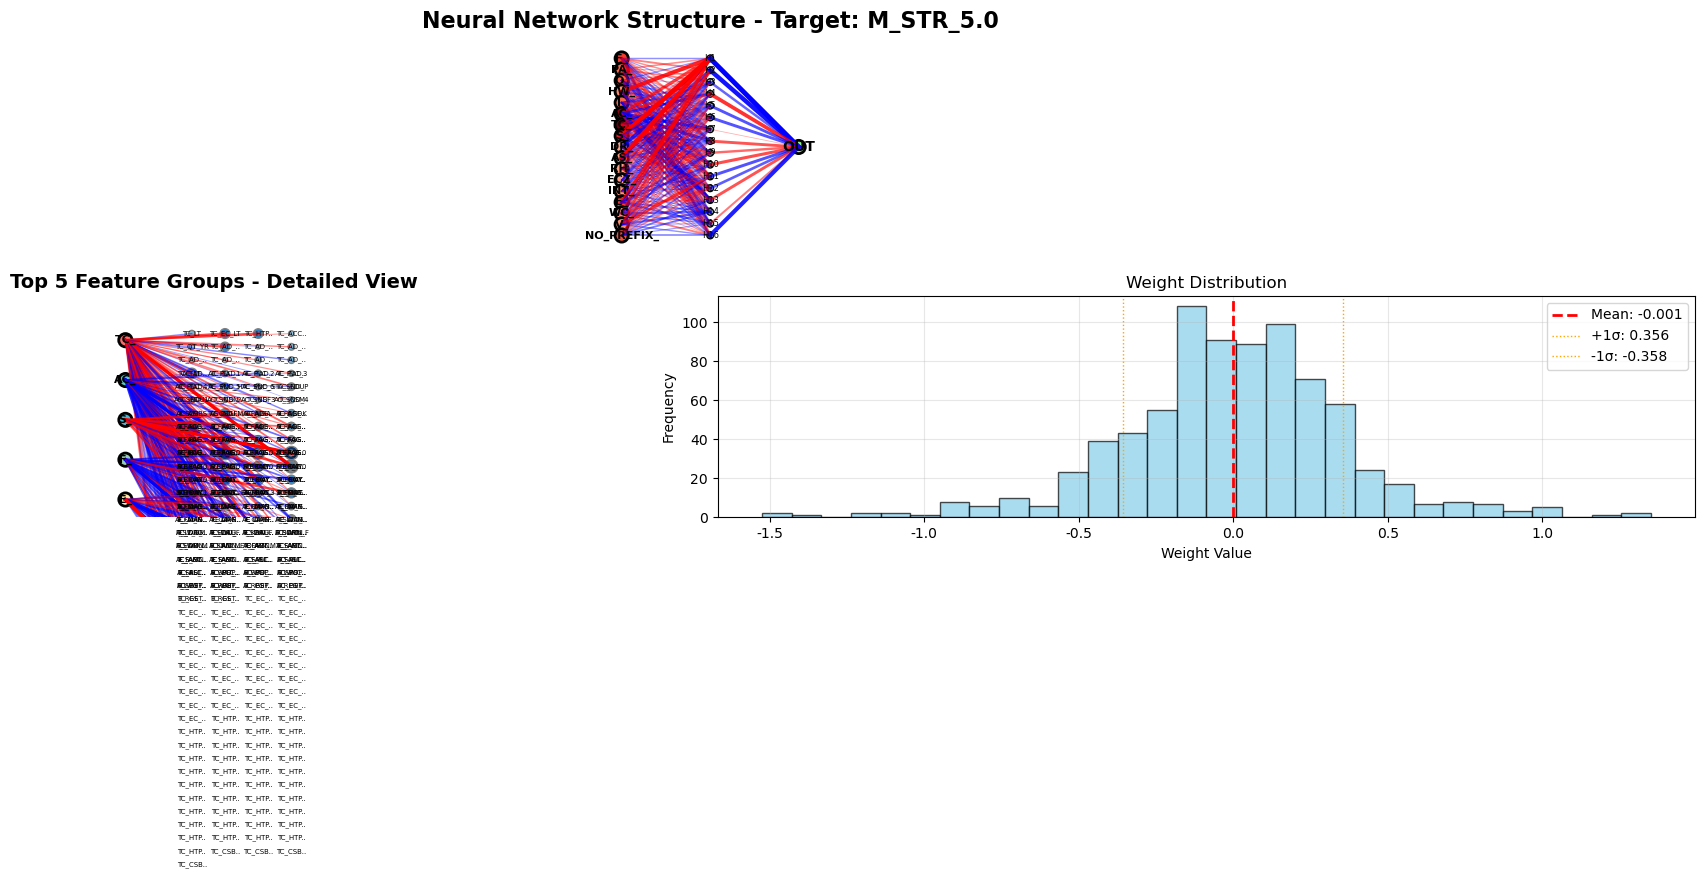

✅ 모델 'M_STR_5.0' 분석 완료!

🚀 모델 학습 시작: Target = M_SLP_EN_1.0
🔄 모델 학습 중...
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 7.

📊 학습 결과 요약 - Target: M_SLP_EN_1.0
🔄 총 에포크 수: 11
📉 최종 Training Loss: 0.2269
📉 최종 Validation Loss: 0.2448
📈 최종 Training Accuracy: 0.9320
📈 최종 Validation Accuracy: 0.9275
📈 최종 테스트 정확도: 0.9275
📉 최종 테스트 Loss: 0.2439

🎨 네트워크 구조 시각화 생성 중...
🎨 네트워크 구조 시각화 생성 중...


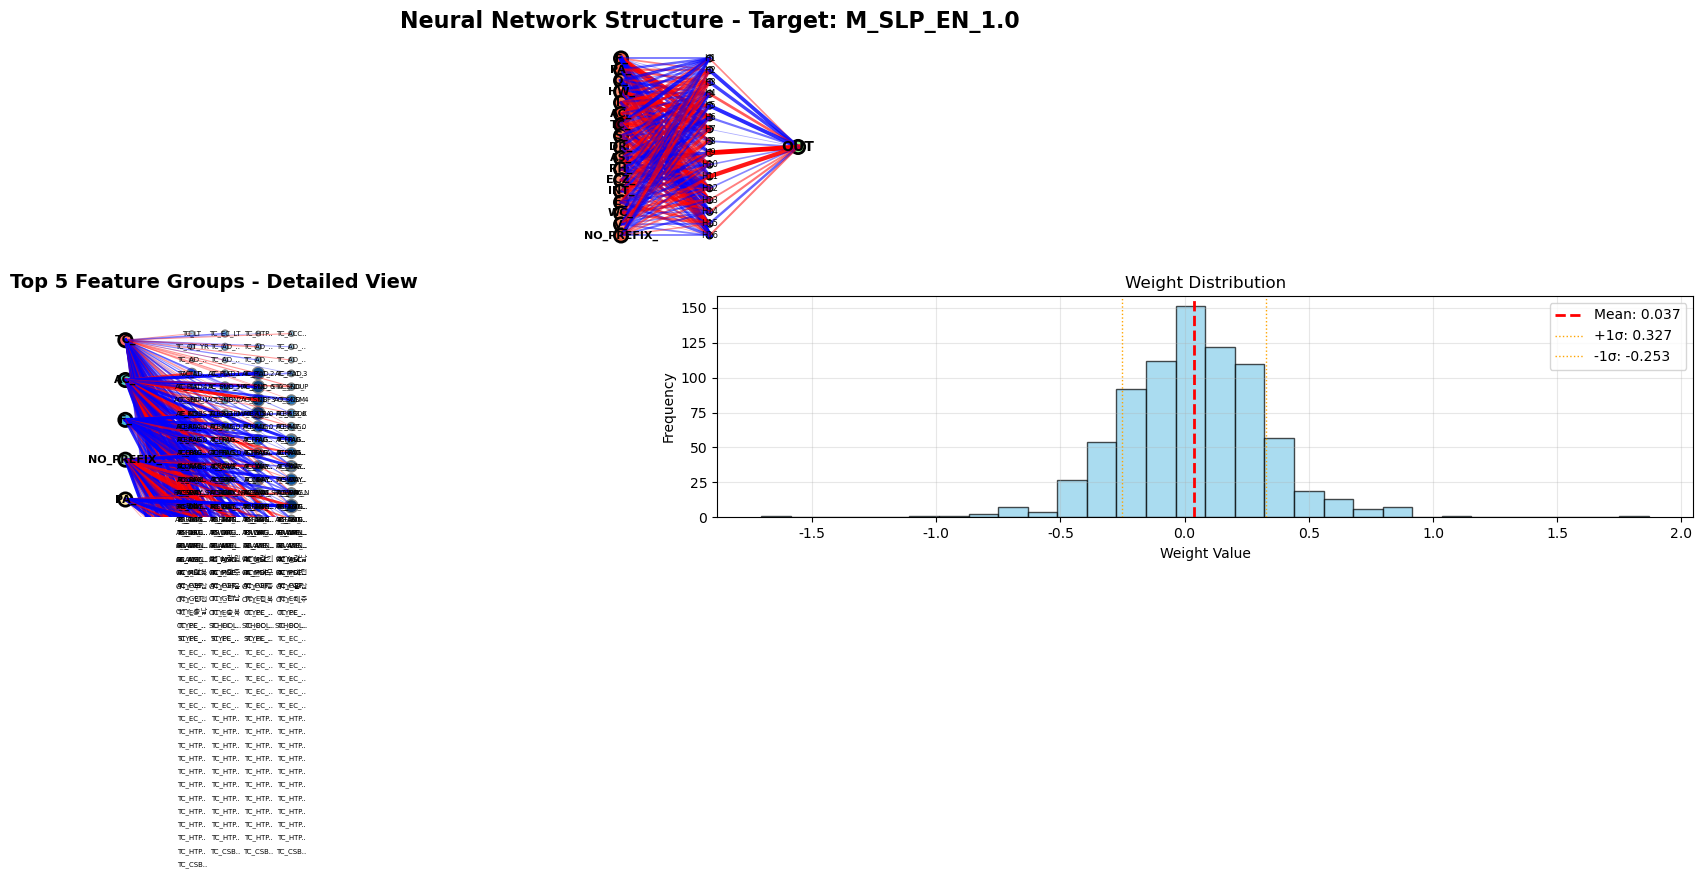

✅ 모델 'M_SLP_EN_1.0' 분석 완료!

🚀 모델 학습 시작: Target = M_SLP_EN_2.0
🔄 모델 학습 중...
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 11.

📊 학습 결과 요약 - Target: M_SLP_EN_2.0
🔄 총 에포크 수: 15
📉 최종 Training Loss: 0.4129
📉 최종 Validation Loss: 0.4110
📈 최종 Training Accuracy: 0.8428
📈 최종 Validation Accuracy: 0.8451
📈 최종 테스트 정확도: 0.8451
📉 최종 테스트 Loss: 0.4106

🎨 네트워크 구조 시각화 생성 중...
🎨 네트워크 구조 시각화 생성 중...


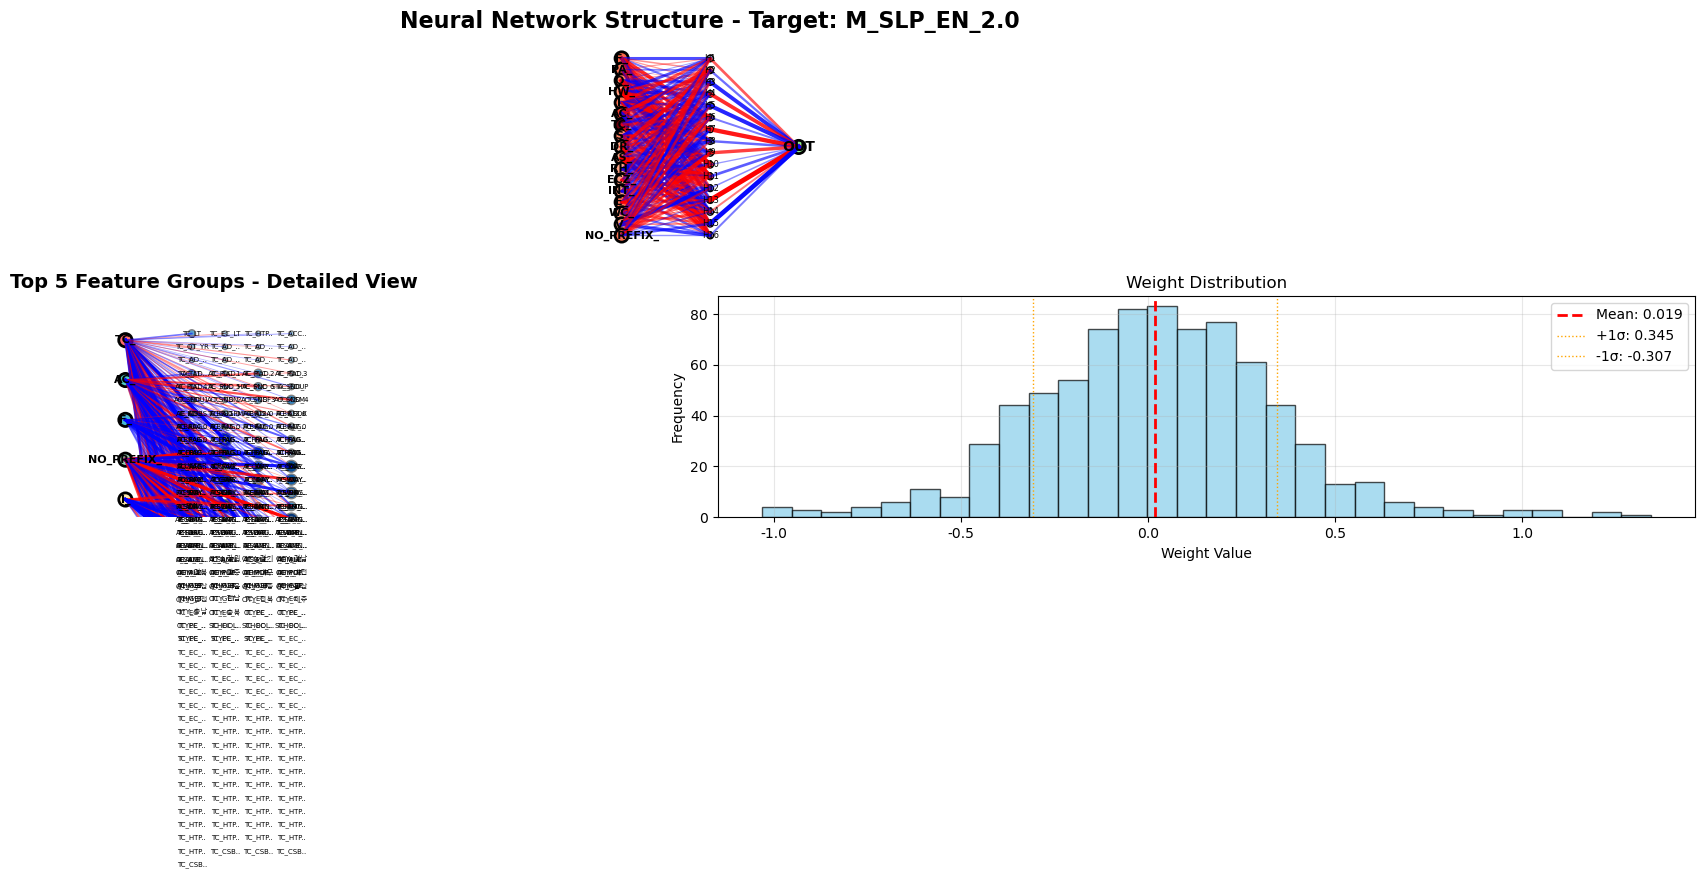

✅ 모델 'M_SLP_EN_2.0' 분석 완료!

🚀 모델 학습 시작: Target = M_SLP_EN_3.0
🔄 모델 학습 중...
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 13.

📊 학습 결과 요약 - Target: M_SLP_EN_3.0
🔄 총 에포크 수: 17
📉 최종 Training Loss: 0.6063
📉 최종 Validation Loss: 0.6059
📈 최종 Training Accuracy: 0.6959
📈 최종 Validation Accuracy: 0.7001
📈 최종 테스트 정확도: 0.7001
📉 최종 테스트 Loss: 0.6040

🎨 네트워크 구조 시각화 생성 중...
🎨 네트워크 구조 시각화 생성 중...


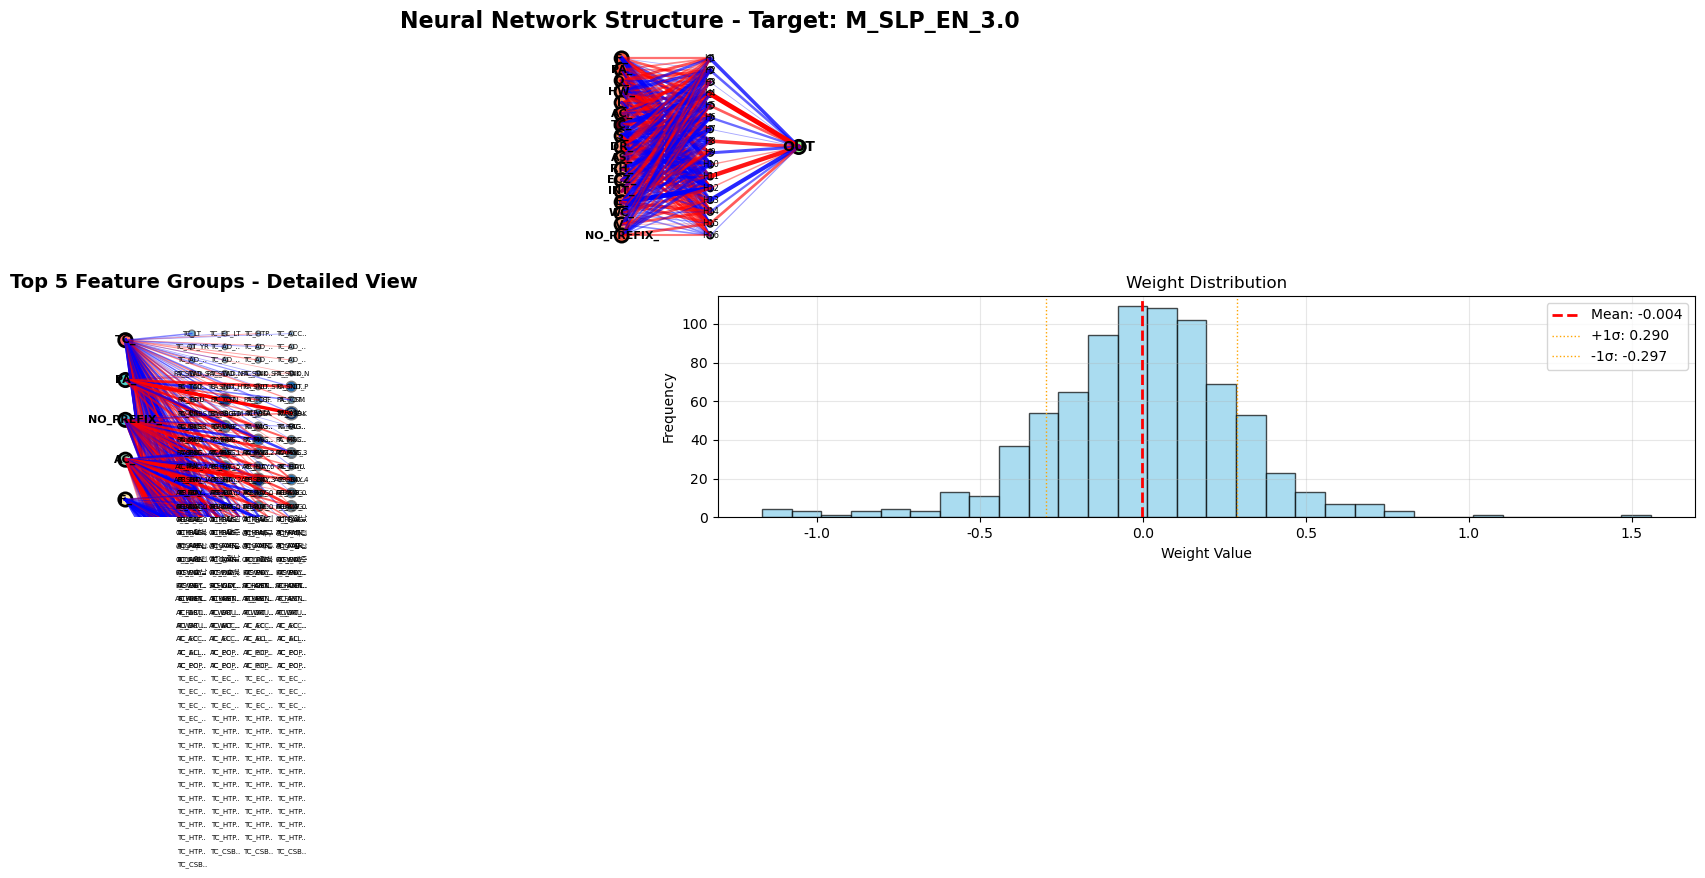

✅ 모델 'M_SLP_EN_3.0' 분석 완료!

🚀 모델 학습 시작: Target = M_SLP_EN_4.0
🔄 모델 학습 중...
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 8.

📊 학습 결과 요약 - Target: M_SLP_EN_4.0
🔄 총 에포크 수: 12
📉 최종 Training Loss: 0.6038
📉 최종 Validation Loss: 0.6161
📈 최종 Training Accuracy: 0.6892
📈 최종 Validation Accuracy: 0.6808
📈 최종 테스트 정확도: 0.6811
📉 최종 테스트 Loss: 0.6149

🎨 네트워크 구조 시각화 생성 중...
🎨 네트워크 구조 시각화 생성 중...


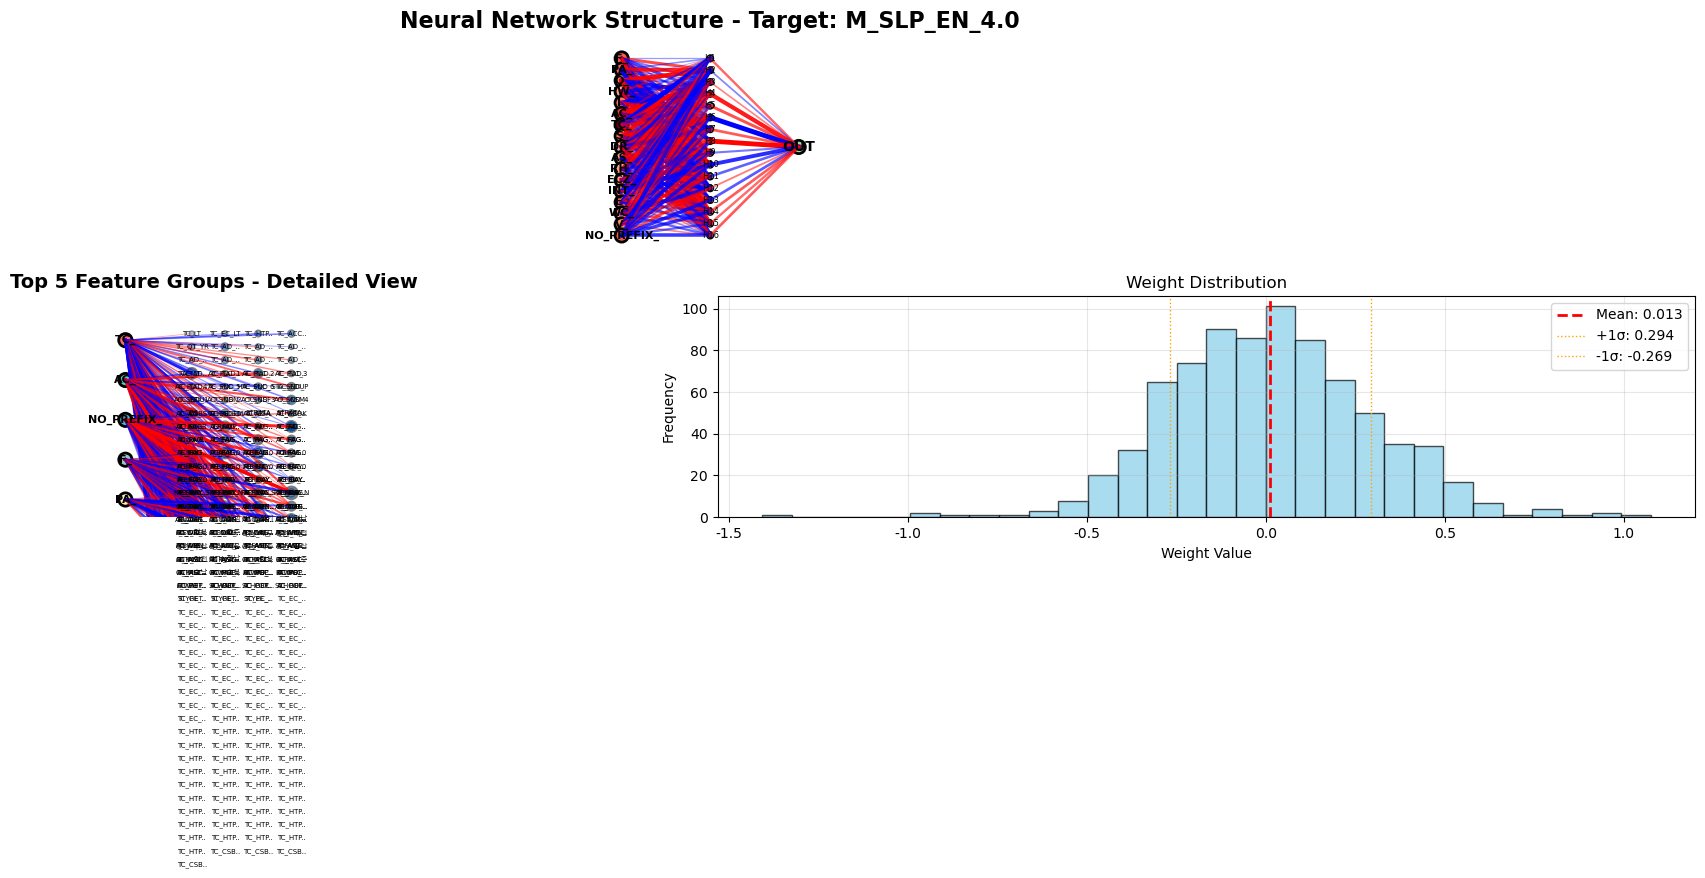

✅ 모델 'M_SLP_EN_4.0' 분석 완료!

🚀 모델 학습 시작: Target = M_SLP_EN_5.0
🔄 모델 학습 중...
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 9.

📊 학습 결과 요약 - Target: M_SLP_EN_5.0
🔄 총 에포크 수: 13
📉 최종 Training Loss: 0.4006
📉 최종 Validation Loss: 0.3978
📈 최종 Training Accuracy: 0.8423
📈 최종 Validation Accuracy: 0.8464
📈 최종 테스트 정확도: 0.8450
📉 최종 테스트 Loss: 0.3976

🎨 네트워크 구조 시각화 생성 중...
🎨 네트워크 구조 시각화 생성 중...


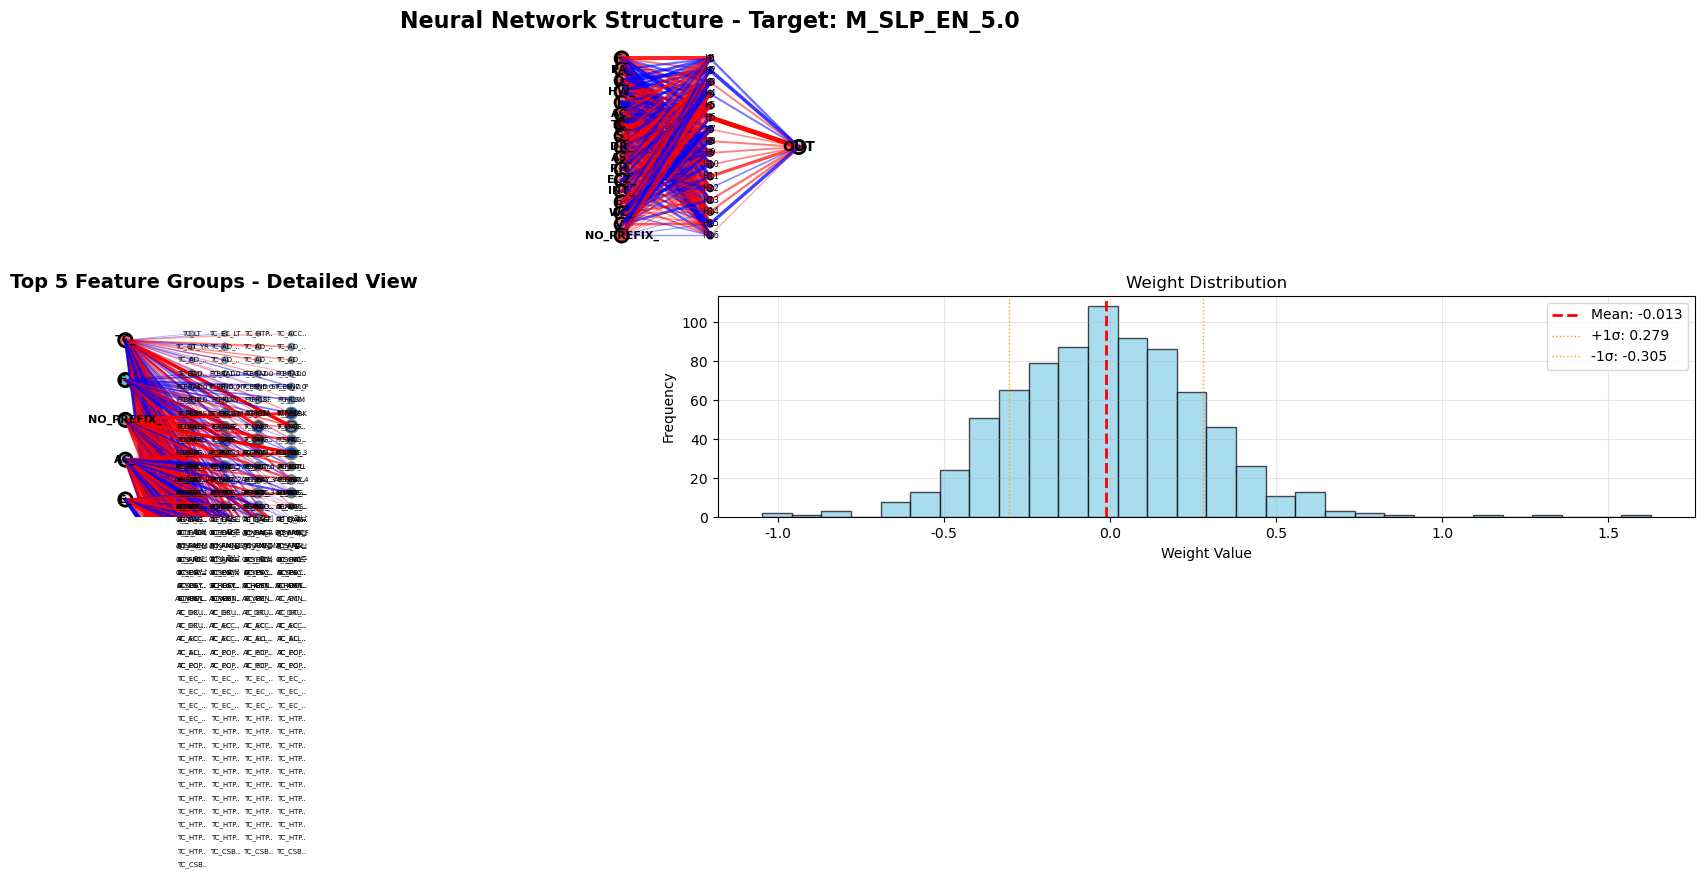

✅ 모델 'M_SLP_EN_5.0' 분석 완료!

🚀 모델 학습 시작: Target = M_LON_1.0
🔄 모델 학습 중...
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 12.

📊 학습 결과 요약 - Target: M_LON_1.0
🔄 총 에포크 수: 16
📉 최종 Training Loss: 0.4364
📉 최종 Validation Loss: 0.4501
📈 최종 Training Accuracy: 0.8145
📈 최종 Validation Accuracy: 0.8061
📈 최종 테스트 정확도: 0.8065
📉 최종 테스트 Loss: 0.4487

🎨 네트워크 구조 시각화 생성 중...
🎨 네트워크 구조 시각화 생성 중...


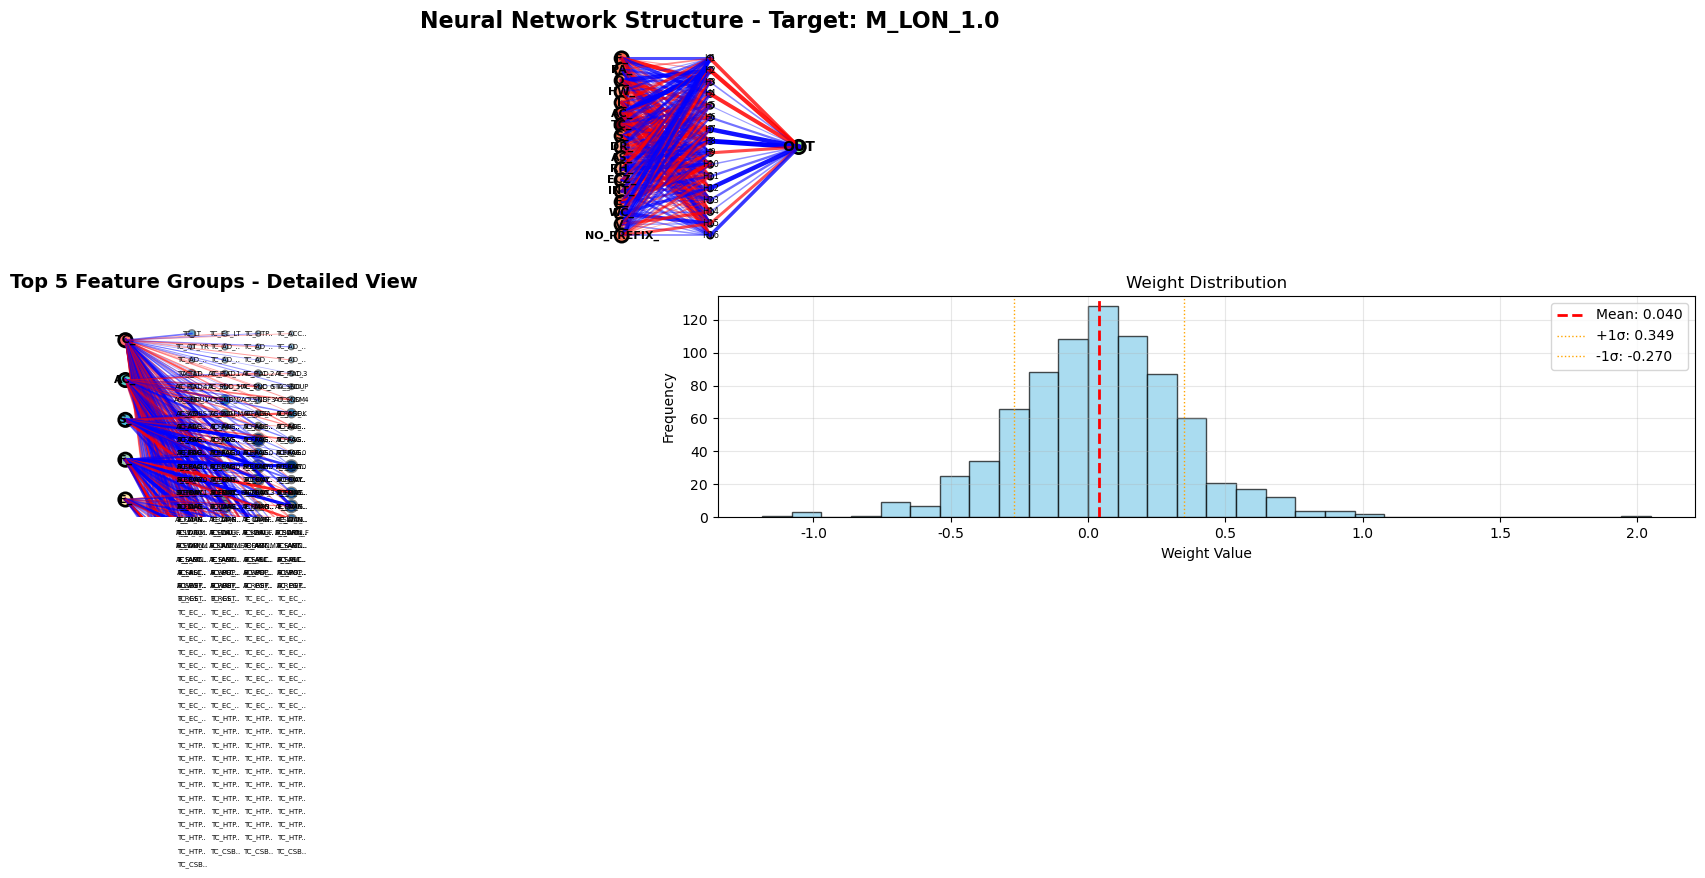

✅ 모델 'M_LON_1.0' 분석 완료!

🚀 모델 학습 시작: Target = M_LON_2.0
🔄 모델 학습 중...
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 11.

📊 학습 결과 요약 - Target: M_LON_2.0
🔄 총 에포크 수: 15
📉 최종 Training Loss: 0.5563
📉 최종 Validation Loss: 0.5557
📈 최종 Training Accuracy: 0.7426
📈 최종 Validation Accuracy: 0.7455
📈 최종 테스트 정확도: 0.7455
📉 최종 테스트 Loss: 0.5547

🎨 네트워크 구조 시각화 생성 중...
🎨 네트워크 구조 시각화 생성 중...


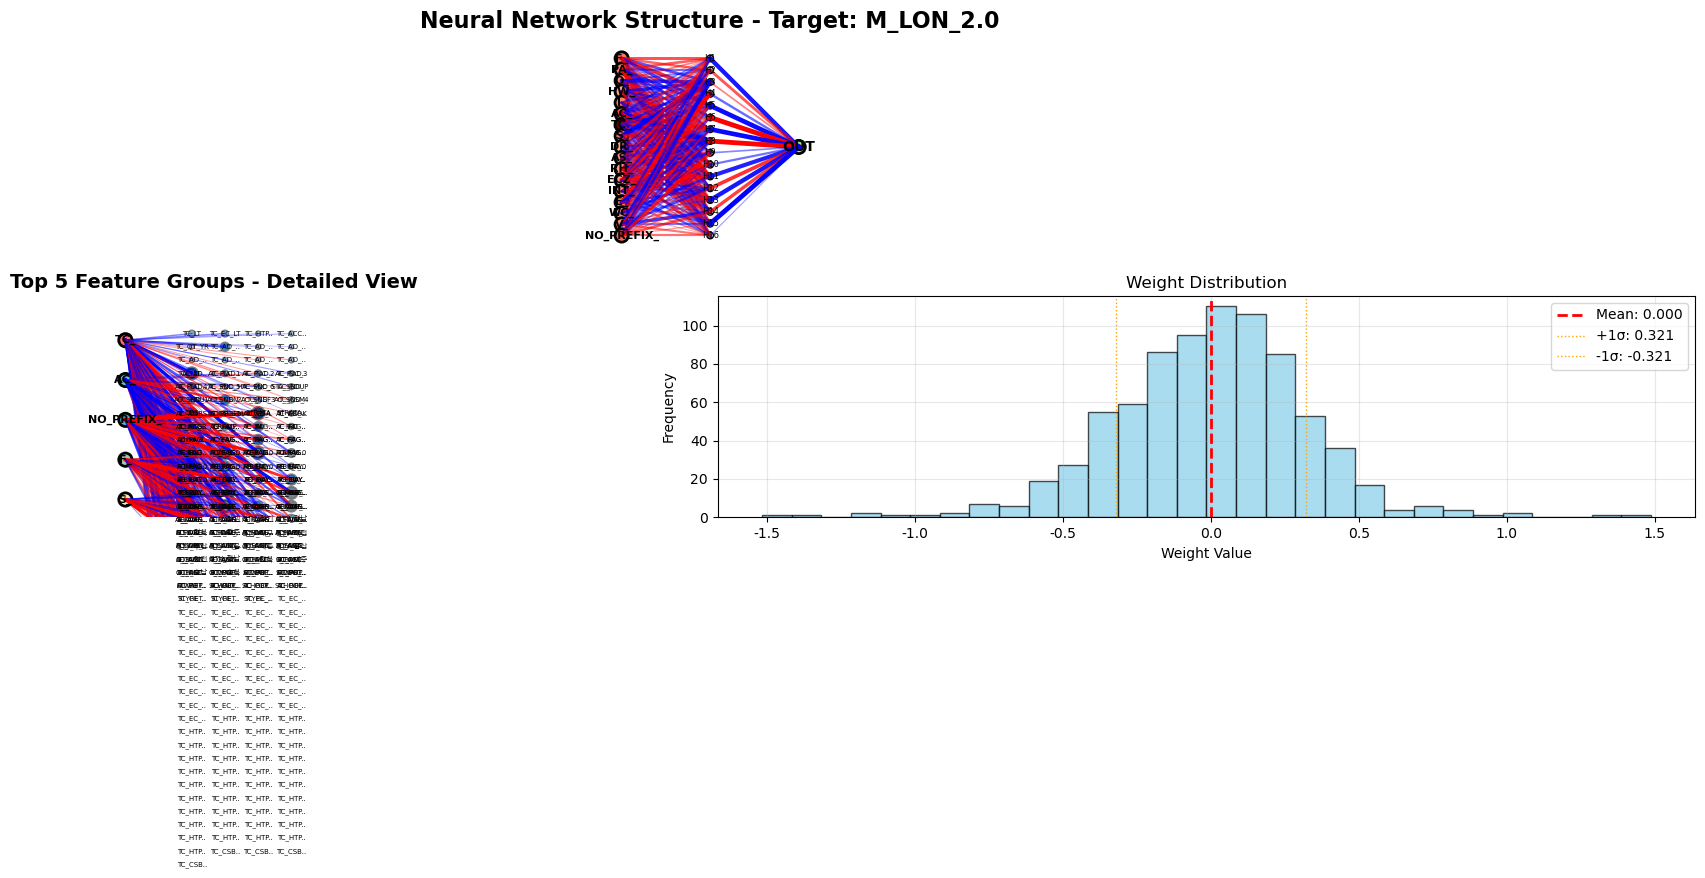

✅ 모델 'M_LON_2.0' 분석 완료!

🚀 모델 학습 시작: Target = M_LON_3.0
🔄 모델 학습 중...
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 9.

📊 학습 결과 요약 - Target: M_LON_3.0
🔄 총 에포크 수: 13
📉 최종 Training Loss: 0.6440
📉 최종 Validation Loss: 0.6452
📈 최종 Training Accuracy: 0.6325
📈 최종 Validation Accuracy: 0.6335
📈 최종 테스트 정확도: 0.6337
📉 최종 테스트 Loss: 0.6449

🎨 네트워크 구조 시각화 생성 중...
🎨 네트워크 구조 시각화 생성 중...


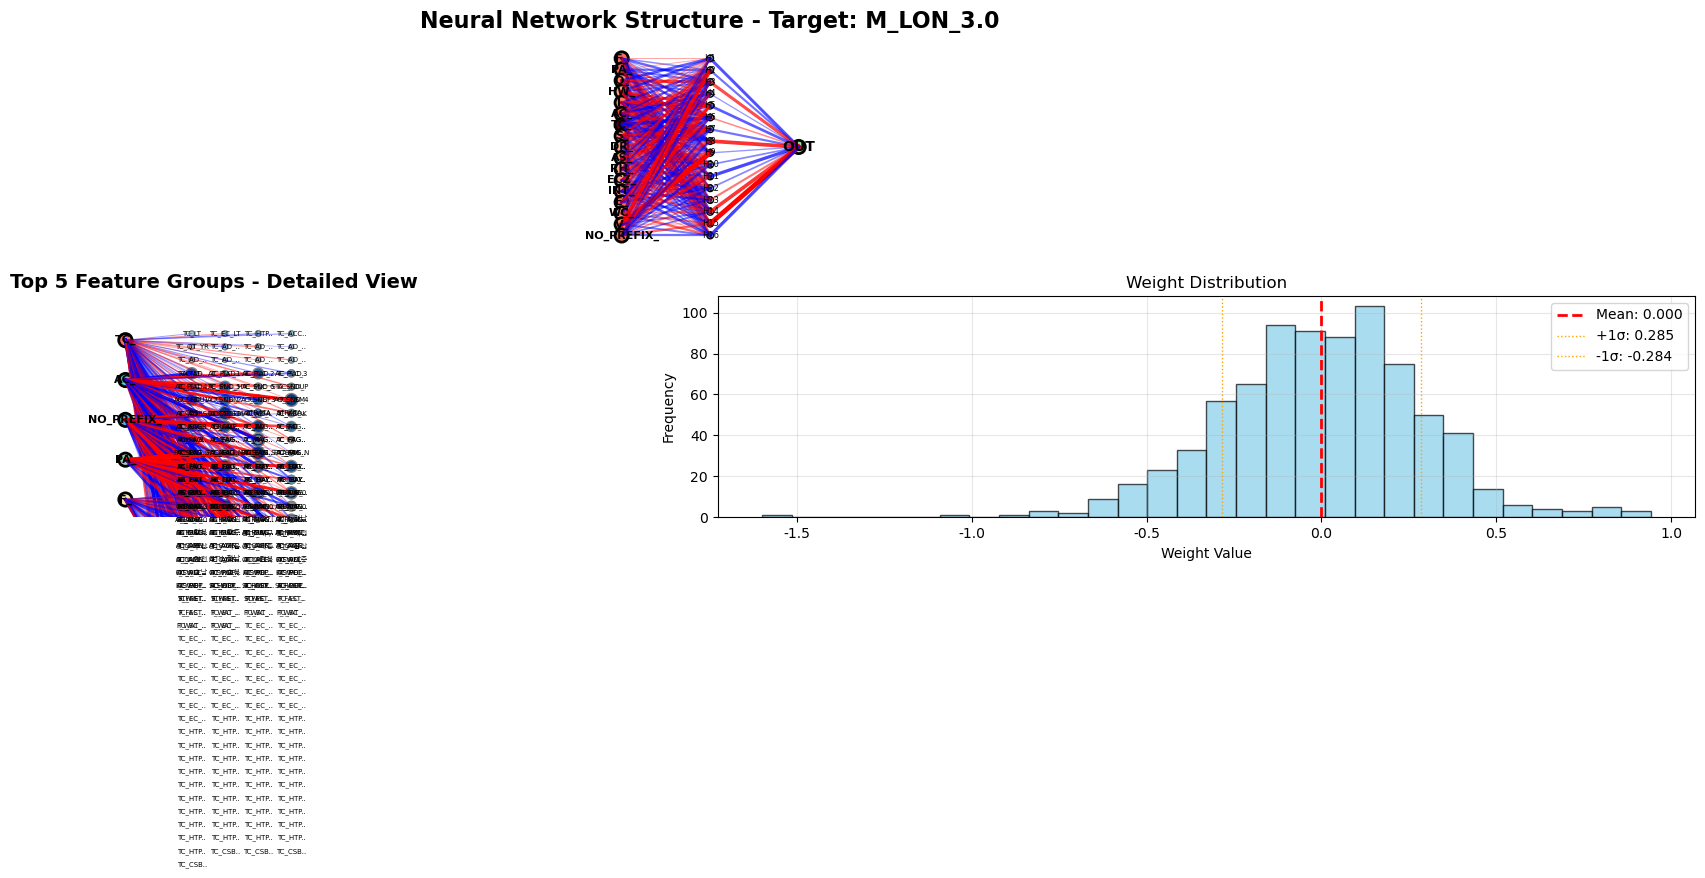

✅ 모델 'M_LON_3.0' 분석 완료!

🚀 모델 학습 시작: Target = M_LON_4.0
🔄 모델 학습 중...
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 15.

📊 학습 결과 요약 - Target: M_LON_4.0
🔄 총 에포크 수: 19
📉 최종 Training Loss: 0.3922
📉 최종 Validation Loss: 0.3961
📈 최종 Training Accuracy: 0.8540
📈 최종 Validation Accuracy: 0.8542
📈 최종 테스트 정확도: 0.8544
📉 최종 테스트 Loss: 0.3960

🎨 네트워크 구조 시각화 생성 중...
🎨 네트워크 구조 시각화 생성 중...


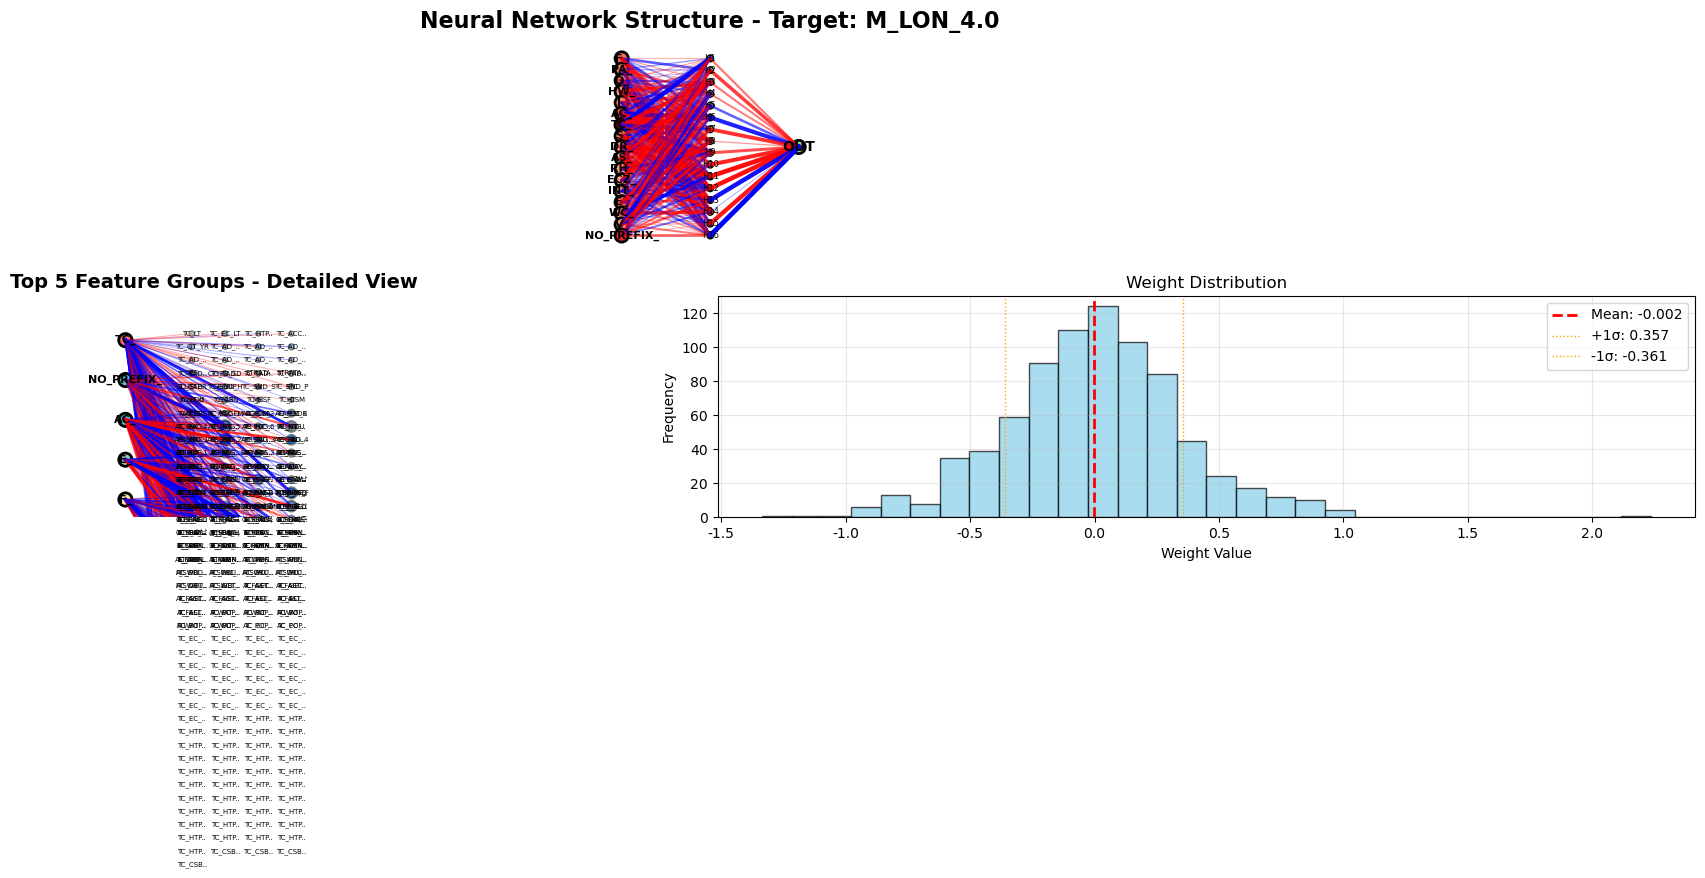

✅ 모델 'M_LON_4.0' 분석 완료!

🚀 모델 학습 시작: Target = M_LON_5.0
🔄 모델 학습 중...
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 8.

📊 학습 결과 요약 - Target: M_LON_5.0
🔄 총 에포크 수: 12
📉 최종 Training Loss: 0.1494
📉 최종 Validation Loss: 0.1550
📈 최종 Training Accuracy: 0.9605
📈 최종 Validation Accuracy: 0.9597
📈 최종 테스트 정확도: 0.9598
📉 최종 테스트 Loss: 0.1534

🎨 네트워크 구조 시각화 생성 중...
🎨 네트워크 구조 시각화 생성 중...


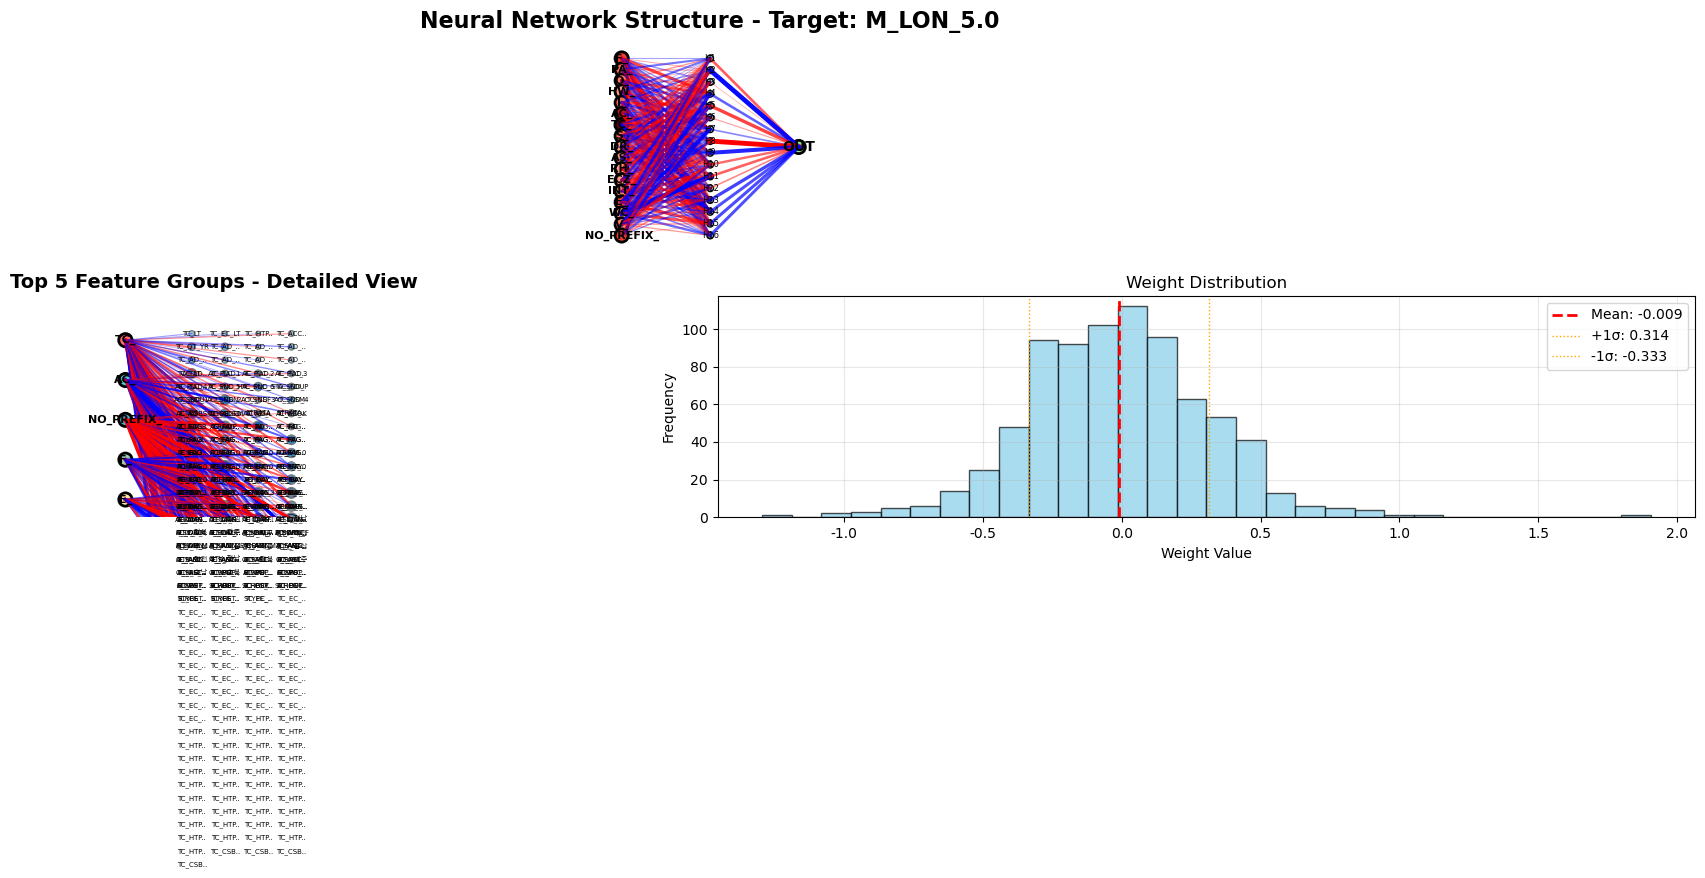

✅ 모델 'M_LON_5.0' 분석 완료!

🎉 전체 학습 완료! 총 28개 모델이 학습되었습니다.


In [13]:
# 메인 학습 루프
history_dict = {}  # 모델별 학습 기록 저장

for target_col in m_targets:
    print(f"\n{'='*50}")
    print(f"🚀 모델 학습 시작: Target = {target_col}")
    print(f"{'='*50}")

    # 데이터 분리 (매번 동일하게 분리하기 위해 random_state 고정)
    X = df[all_features]
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # --- Keras Functional API를 사용한 모델 구축 ---
    # 1단계: Prefix 그룹별 입력 및 1차 처리 레이어
    input_layers = []
    processed_outputs = []

    for prefix, cols in feature_groups.items():
        # 각 그룹에 맞는 입력층 생성
        group_input = Input(shape=(len(cols),), name=f'input_{prefix}')
        input_layers.append(group_input)
        
        # 각 그룹을 하나의 노드로 압축하는 Dense 레이어
        group_output = Dense(1, activation='relu', name=f'processed_{prefix}')(group_input)
        processed_outputs.append(group_output)

    # 2단계: 1차 처리된 노드들 결합
    concatenated = Concatenate()(processed_outputs)

    # (선택) 중간에 은닉층(Hidden Layer) 추가
    hidden_layer = Dense(16, activation='relu', name='hidden_layer_1')(concatenated)

    # 3단계: 최종 출력 레이어
    output_layer = Dense(1, activation='sigmoid', name='output_layer')(hidden_layer)
    
    # 모델 정의
    model_inputs = [X_train[cols] for prefix, cols in feature_groups.items()]
    test_inputs = [X_test[cols] for prefix, cols in feature_groups.items()]

    model = Model(inputs=list(input_layers), outputs=output_layer)

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    # Early Stopping 콜백 설정 (validation loss 기준, 4번의 patience)
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=4,
        restore_best_weights=True,
        verbose=1
    )

    # 모델 학습 (Early Stopping 적용)
    print("🔄 모델 학습 중...")
    history = model.fit(
        model_inputs,
        y_train,
        validation_data=(test_inputs, y_test),
        epochs=100,  # 최대 에포크 수 (early stopping으로 조기 종료됨)
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0
    )

    history_dict[target_col] = history
    
    # 학습 결과 출력
    print_training_summary(history, target_col)
    
    # 모델 평가
    loss, accuracy = model.evaluate(test_inputs, y_test, verbose=0)
    print(f"📈 최종 테스트 정확도: {accuracy:.4f}")
    print(f"📉 최종 테스트 Loss: {loss:.4f}")
    
    # 가중치 시각화 (SPSS 스타일 네트워크 다이어그램)
    print(f"\n🎨 네트워크 구조 시각화 생성 중...")
    weight_analysis = visualize_model_weights(model, feature_groups, target_col)
    
    print(f"✅ 모델 '{target_col}' 분석 완료!")

print(f"\n🎉 전체 학습 완료! 총 {len(m_targets)}개 모델이 학습되었습니다.")